## Fraud Prediction

### Load Libraries
    * Libraries for data preparation
    * Fast ML Libraries for data imputation and encoding
        - for installing fast-ml use command "pip install fast-ml" in command prompt
    * sklearn libraries for modelling, confusion matrix and prediction
    

In [1]:
#Import os, pandas and numpy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from lightgbm import LGBMClassifier
import datetime

In [2]:
from fast_ml.eda import categorical_plots,numerical_plots
from fast_ml.missing_data_analysis import MissingDataAnalysis
from fast_ml.missing_data_imputation import MissingDataImputer_Categorical, MissingDataImputer_Numerical
from fast_ml.utilities import rare_encoding
from fast_ml.feature_engineering import FeatureEngineering_Categorical,FeatureEngineering_Numerical
from fast_ml.utilities import reduce_memory_usage
from fast_ml.eda import categorical_plots,numerical_plots,categorical_plots_with_target,numerical_plots_with_target,numerical_bins_with_target


In [3]:
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

#### Functions

* "compare_Numerical_distribution" function to compare distribution of numerical data before and after imputation
* "clustercheck" to check if the set of variables belong to the same cluster.
* "Browser_transform","OS_transform" and "Mail_transform" to normalize the observation in variables,

In [4]:

def compare_Numerical_distribution(df1,df2,variables):
    df = pd.DataFrame()
    msg_value = []
    data = []
    for a in variables:
        df_mean = df1[a].mean() - df2[a].mean()
        df_std = df1[a].std() - df2[a].std()
        if int(df_mean) == 0:
            msg_mean = "Mean of both the dataset is same" #+ str(df1[a].mean()) + str(df2[a].mean()) 
        else:
            msg_mean = "Mean of both the dataset differ by " + str(df_mean)
        if int(df_std) == 0:
            msg_std = "Standard Dev. of both the dataset is same"
        else:
            msg_std = "Standard Dev the dataset differ by " + str(df_std) 
            
        if int(df_mean) == 0 and int(df_std) ==0:
            msg_Remark = "Distribution for dataset is same"
            
        else:
            msg_Remark = "Distribution for dataset is different"
            
        msg_value = [a,msg_mean,msg_std,msg_Remark] 
        zipped  = zip(["Variable","Mean","Stdev","Remark"],msg_value)
        a_dict = dict(zipped)
        data.append(a_dict)
    df= df.append(data,True)
    return(df)


def clustercheck(df,base,cluster):
    nullcount = df[base].isnull().sum()
    LiTrue = []
    LiFalse = []
    for a in cluster:
        if df[a].isnull().sum() == nullcount:
            LiTrue.append(a)
        else:
            LiFalse.append(a)

    print("List of elements having same missing value is", LiTrue)
    print("List of elements having different missing value is", LiFalse)
    
def Browser_transform(df,col):
    df.loc[df[col].str.contains('chrome', na=False), col] = 'Chrome'
    df.loc[df[col].str.contains('firefox', na=False), col] = 'Firefox'
    df.loc[df[col].str.contains('safari', na=False), col] = 'Safari'
    df.loc[df[col].str.contains('edge', na=False), col] = 'Edge'
    df.loc[df[col].str.contains('ie', na=False), col] = 'IE'
    df.loc[df[col].str.contains('samsung', na=False), col] = 'Samsung'
    df.loc[df[col].str.contains('opera', na=False), col] = 'Opera'
    #df.loc[df[col].str.contains('Others', na=False), col] = 'other'
    df[col].fillna("Missing", inplace=True)
    df.loc[df.id_31.isin(df.id_31.value_counts()[df.id_31.value_counts() < 200].index), col] = "other"
    
def OS_transform(df,col):
    df.loc[df[col].str.contains('Windows', na=False), col] = 'Windows'
    df.loc[df[col].str.contains('iOS', na=False), col] = 'iOS'
    df.loc[df[col].str.contains('Mac OS', na=False), col] = 'Mac'
    df.loc[df[col].str.contains('Android', na=False), col] = 'Android'
    df[col].fillna("Missing", inplace=True)
    
def Mail_transform(df,col):
    df.loc[df[col].str.contains('gmail', na=False), col] = 'gmail.com'
    df.loc[df[col].str.contains('yahoo', na=False), col] = 'yahoo.com'
    df.loc[df[col].str.contains('outlook', na=False), col] = 'outlook.com'
    df.loc[df[col].str.contains('hotmail', na=False), col] = 'hotmail.com'
    df[col].fillna("Missing", inplace=True)
    
def Remove_dup(x):
    return list(dict.fromkeys(x))

    #return df   


### Import Data

In [5]:
n = 590540 #number of records in file
s = 50000 #desired sample size
filename = "D:\\Kaggle\\Fraud_Detection\\train_transaction.csv"
skip = sorted(random.sample(range(n),n-s))
train = pd.read_csv(filename, skiprows=skip[1:])
#train_transaction =  pd.read_csv("")
#train_identity = pd.read_csv("D:\\Kaggle\\Fraud_Detection\\train_identity.csv")
#train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [7]:
train = reduce_memory_usage(train, convert_to_category=False)

Memory usage of dataframe is 150.30 MB
Memory usage after optimization is: 45.54 MB
Decreased by 69.7%


## Test Train Split

* Create Test, Train and Validate DataSet

In [6]:
y = train['isFraud']
x_train = train.drop('isFraud', axis =1)
from sklearn.model_selection import train_test_split
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y, test_size=0.2, random_state=0)
#from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [7]:
#from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [8]:
x_train.shape,y_train.shape

((32000, 393), (32000,))

In [9]:
X_test.shape,y_test.shape

((8000, 393), (8000,))

In [10]:
x_valid.shape,y_valid.shape

((10001, 393), (10001,))

#####  Identify variables Based on EDA performed

In [11]:
Rare_2 =['P_emaildomain']
Rare_4 =['R_emaildomain']
#'D5' : [0,30,40,50,60,70,80,90,100],
Custom_Bin ={
'TransactionAmt' : [0,10,20,40,50,60,70,90,100],
'C1' : [0,50,70,80,90,100],
'C2' : [0,50,70,80,90,100],
'C4' : [0,70,90,100],
'C5' : [0,60,80,90,100],
'C6' : [0,60,80,90,100],
'C7' : [0,80,90,100],
'C8' : [0,70,90,100],
'C9' : [0,60,80,90,100],
'C10' : [0,70,90,100],
'C11' : [0,60,80,90,100],
'C12' : [0,80,90,100],
'C13' : [0,10,50,60,70,80,90,100],
'C14' : [0,80,90,100],
'D1' : [0,50,60,70,80,90,100],
'addr1' : [0,90,100],
'D10' : [0,50,60,70,80,90,100],
'D15' : [0,30,40,50,60,70,80,90,100],
'D4' : [0,10,50,60,70,80,90,100],
'D3' : [0,30,40,50,60,100],
'D2' : [0,10,20,30,40,50,60,70,100],
'D11' : [0,40,50,60,70,80,90,100],
'D6' : [0,70,80,90,100],
'D12' : [0,70,80,90,100],
'D14' : [0,70,80,90,100],
'D13' : [0,90,100],
'D7' : [0,60,90,100],'V330': [0, 90, 100],'V329': [0, 90, 100],'V326': [0, 90, 100],'V334': [0, 98, 100],
'V337': [0, 95, 100],'V339': [0, 90, 100],	'V336': [0, 95, 100],	'V338': [0, 90, 100],	'V322': [0, 95, 100],
             'V324': [0, 80, 100],	'V323': [0, 90, 100],	'V335': [0, 90, 100],	'V331': [0, 90, 100],
             'V333': [0, 80, 100],	'V332': [0, 80, 100],	'V311': [0, 98, 100],	'V319': [0, 98, 100],
             'V321': [0, 95, 100],	'V309': [0, 95, 100],	'V320': [0, 95, 100],	'V316': [0, 95, 100],
             'V313': [0, 90, 100],	'V318': [0, 95, 100],	'V315': [0, 90, 100],	'V312': [0, 80, 90, 100],
             'V317': [0, 90, 100],	'V306': [0, 90, 100],	'V314': [0, 90, 100],	'V308': [0, 80, 100],
             'V310': [0, 70, 80, 90, 100],'V307': [0, 60, 80, 100]}



In [12]:
Adaptive_10p = ['card1' ,'card3','card5' ,'card2' ,'dist1' ,'D8','dist2','V225',	'V193',	'V190',	'V170',	'V237',
                'V176',	'V192',	'V199',	'V261',	'V171',	'V243',	'V254',	'V236',	'V246',	'V255',	'V256',	'V257',	'V227',
                'V299',	'V151',	'V182',	'V228',	'V201',	'V245',	'V290',	'V283',	'V144',	'V180',	'V230',	'V253',	'V258',
                'V259',	'V222',	'V221',	'V224',	'V226',	'V229',	'V296',	'V298',	'V285',	'V187',	'V234',	'V269',	'V292',	
                'V291',	'V145',	'V177',	'V167',	'V143',	'V179',	'V168',	'V178',	'V231',	'V217',	'V233',	'V232',	'V219',
                'V218',	'V166',	'V164',	'V129',	'V293',	'V279',	'V295',	'V165',	'V280',	'V150',	'V135',	'V294',	'V137',
                'V206',	'V159',	'V136',	'V266',	'V131',	'V205',	'V132',	'V270',	'V160',	'V272',	'V208',	'V210',	'V276',
                'V214',	'V268',	'V271',	'V278',	'V134',	'V216',	'V277',	'V209',	'V207',	'V215',	'V267',	'V126',	'V133',
                'V128',	'V273',	'V275',	'V130',	'V211',	'V127',	'V274',	'V213',	'V212',	'V263',	'V202',	'V265',	'V204',
                'V264',	'V203']
Adaptive_5p = ['V200',	'V106',	'V105',	'V161',	'V163',	'V162',	'V101',	'V103',	'V102']


In [13]:
Rare_5 = ['ProductCD',	'card4',	'card6',	'addr2',	'M6',	'M1',	'M2',	'M3',	'M4',	'M7',	'M8',	'M9',	'M5',	'D9',
'V9',	'V8',	'V5',	'V4',	'V3',	'V2',	'V11',	'V10',	'V50',	'V49',	'V48',	'V42',	'V41',	'V40',	'V36',	'V35',	'V94',	'V93',
          'V92',	'V91',	'V90',	'V89',	'V88',	'V87',	'V86',	'V85',	'V84',	'V83',	'V82',	'V81',	'V80',	'V79',	'V77',	'V74',	'V73',
          'V72',	'V71',	'V70',	'V69',	'V68',	'V67',	'V65',	'V64',	'V63',	'V62',	'V60',	'V59',	'V58',	'V57',	'V55',	'V53',	'V34',
          'V33',	'V32',	'V31',	'V30',	'V29',	'V28',	'V27',	'V26',	'V25',	'V24',	'V22',	'V21',	'V19',	'V18',	'V17',	'V16',	'V15',
          'V14',	'V13',	'V12',	'V98','V141',	'V173',	'V325',	'V142',	'V174',	'V194',	'V197',	'V301',	'V153',	'V302',	'V304',	'V148',	'V154',
          'V155',	'V157',	'V175',	'V184',	'V123',	'V195',	'V303',	'V138',	'V328',	'V146',	'V156',	'V327',	'V158',	'V198',	'V147',	'V185',	'V181',
          'V169',	'V188']
Rare_10 = ['V107',	'V117',	'V118',	'V119',	'V120',	'V121',	'V122',	'V108',	'V109',	'V110',	'V111',	'V112',	'V113',	'V114',	'V115',	'V116',	'V124',
           'V125',	'V104']


In [14]:
# Variable to drop
Var_to_Drop = ['C3','TransactionID','TransactionDT']

##### Drop unwanted Variables

In [15]:
x_train = x_train.drop(Var_to_Drop,axis=1)
x_valid = x_valid.drop(Var_to_Drop,axis=1)

##### Feature engineering to string variables

In [16]:
#Browser_transform(x_train,'id_31')
#OS_transform(x_train,'id_30')
Mail_transform(x_train,'P_emaildomain')
Mail_transform(x_train,'R_emaildomain')

#Browser_transform(x_valid,'id_31')
#OS_transform(x_valid,'id_30')
Mail_transform(x_valid,'P_emaildomain')
Mail_transform(x_valid,'R_emaildomain')

### Rare Encoding

In [17]:
rare_encoder2 = FeatureEngineering_Categorical( method='rare')
rare_encoder2.fit(x_train, Rare_2, target=None, rare_tol=2)
x_train = rare_encoder2.transform(x_train)
x_valid = rare_encoder2.transform(x_valid)

In [18]:
rare_encoder3 = FeatureEngineering_Categorical( method='rare')
rare_encoder3.fit(x_train, Rare_4, target=None, rare_tol=4)
x_train = rare_encoder3.transform(x_train)
x_valid = rare_encoder3.transform(x_valid)

In [19]:
rare_encoder4 = FeatureEngineering_Categorical( method='rare')
rare_encoder4.fit(x_train, Rare_5, target=None, rare_tol=5)
x_train = rare_encoder4.transform(x_train)
x_valid = rare_encoder4.transform(x_valid)

In [20]:
rare_encoder5 = FeatureEngineering_Categorical( method='rare')
rare_encoder5.fit(x_train, Rare_10, target=None, rare_tol=10)
x_train = rare_encoder5.transform(x_train)
x_valid = rare_encoder5.transform(x_valid)

In [21]:
len(rare_encoder4.param_dict_)

119

### Binning

In [22]:
### ADAPTIVE 10 PERCENTILE BINNING 

from fast_ml.feature_engineering import FeatureEngineering_Numerical
num_binner = FeatureEngineering_Numerical(method = '10p', adaptive = True)
num_binner.fit(x_train, Adaptive_10p)
x_train = num_binner.transform(x_train)
x_valid = num_binner.transform(x_valid)

[1006.0, 2803.0, 4812.0, 6951.0, 8178.200000000001, 9749.0, 11366.799999999985, 12932.0, 15066.0, 16560.0, 18390.0]
[-inf, 2803.0, 4812.0, 6951.0, 8178.200000000001, 9749.0, 11366.799999999985, 12932.0, 15066.0, 16560.0, inf]
[100.0, 150.0, 159.0, 229.0]
[-inf, 150.0, 159.0, inf]
[100.0, 126.0, 166.0, 195.0, 224.0, 226.0, 237.0]
[-inf, 126.0, 166.0, 195.0, 224.0, 226.0, inf]
[100.0, 112.0, 194.0, 264.0, 321.0, 361.0, 445.0, 490.0, 543.0, 555.0, 600.0]
[-inf, 112.0, 194.0, 264.0, 321.0, 361.0, 445.0, 490.0, 543.0, 555.0, inf]
[0.0, 1.0, 2.0, 4.0, 6.0, 8.0, 12.0, 18.0, 36.0, 278.0, 4894.0]
[-inf, 1.0, 2.0, 4.0, 6.0, 8.0, 12.0, 18.0, 36.0, 278.0, inf]
[0.0, 0.5, 0.8333330154418945, 2.75, 14.366666603088387, 34.79166412353516, 76.66666412353516, 134.8333343505858, 234.8416687011719, 418.91666870117194, 1707.7916259765625]
[-inf, 0.5, 0.8333330154418945, 2.75, 14.366666603088387, 34.79166412353516, 76.66666412353516, 134.8333343505858, 234.8416687011719, 418.91666870117194, inf]
[0.0, 1.0, 

In [23]:
### ADAPTIVE 5 PERCENTILE BINNING 
num_binner2 = FeatureEngineering_Numerical(method = '5p', adaptive = True)
num_binner2.fit(x_train, Adaptive_5p)
x_train = num_binner2.transform(x_train)
x_valid = num_binner2.transform(x_valid)

[0.0, 1.0, 2.0, 39.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 52.0]
[-inf, 1.0, inf]
[0.0, 1.0, 92.0]
[-inf, 1.0, inf]
[0.0, 3000.0]
[-inf, inf]
[0.0, 3000.0]
[-inf, inf]
[0.0, 3000.0]
[-inf, inf]
[0.0, 1.0, 863.0]
[-inf, 1.0, inf]
[0.0, 1.0, 922.0]
[-inf, 1.0, inf]
[0.0, 2.0, 1285.0]
[-inf, 2.0, inf]


In [24]:
for key, value in Custom_Bin.items():
    num_bin_custom = FeatureEngineering_Numerical(method = 'custom', adaptive = False, custom_buckets= value)
    num_bin_custom.fit(x_train,[key])
    print(key,value)
    x_train = num_bin_custom.transform(x_train)
    x_valid = num_bin_custom.transform(x_valid)

[0.5429999999999999, 26.31, 35.95, 57.95, 68.95, 100.0, 117.0, 276.1500000000033, 5279.95]
[-inf, 26.31, 35.95, 57.95, 68.95, 100.0, 117.0, 276.1500000000033, inf]
TransactionAmt [0, 10, 20, 40, 50, 60, 70, 90, 100]
[0.0, 1.0, 2.0, 4.0, 7.0, 4681.0]
[-inf, 1.0, 2.0, 4.0, 7.0, inf]
C1 [0, 50, 70, 80, 90, 100]
[0.0, 1.0, 2.0, 4.0, 7.0, 5690.0]
[-inf, 1.0, 2.0, 4.0, 7.0, inf]
C2 [0, 50, 70, 80, 90, 100]
[0.0, 0.0, 1.0, 2249.0]
[-inf, 0.0, 1.0, inf]
C4 [0, 70, 90, 100]
[0.0, 0.0, 1.0, 3.0, 298.0]
[-inf, 0.0, 1.0, 3.0, inf]
C5 [0, 60, 80, 90, 100]
[0.0, 1.0, 2.0, 5.0, 2249.0]
[-inf, 1.0, 2.0, 5.0, inf]
C6 [0, 60, 80, 90, 100]
[0.0, 0.0, 1.0, 2251.0]
[-inf, 0.0, 1.0, inf]
C7 [0, 80, 90, 100]
[0.0, 0.0, 1.0, 3327.0]
[-inf, 0.0, 1.0, inf]
C8 [0, 70, 90, 100]
[0.0, 1.0, 2.0, 4.0, 204.0]
[-inf, 1.0, 2.0, 4.0, inf]
C9 [0, 60, 80, 90, 100]
[0.0, 0.0, 1.0, 3253.0]
[-inf, 0.0, 1.0, inf]
C10 [0, 70, 90, 100]
[0.0, 1.0, 2.0, 4.0, 3184.0]
[-inf, 1.0, 2.0, 4.0, inf]
C11 [0, 60, 80, 90, 100]
[0.0, 0.0, 1

In [25]:
cat_imputer = MissingDataImputer_Categorical(method = 'custom_value',add_indicator=False,value = 'Missing')
cat_imputer.fit(x_train, variables = Rare_5)
x_train = cat_imputer.transform(x_train)
x_valid = cat_imputer.transform(x_valid)

cat_imputer2 = MissingDataImputer_Categorical(method = 'custom_value',add_indicator=False,value = 'Missing')
cat_imputer2.fit(x_train, variables = Rare_10)
x_train = cat_imputer2.transform(x_train)
x_valid = cat_imputer2.transform(x_valid)

In [26]:
licol = x_train.columns
mda_obj = MissingDataAnalysis(x_train[licol], target='isfraud', model = 'Classification' )
X_miss = mda_obj.calculate_missing_values()
x_missvar = X_miss.variables
catcol =[]
numcol = []
for col in x_missvar:
    if len(x_train[col].unique()) <=20 :
        catcol.append(col)
    else:
        numcol.append(col)
#catcol.extend(["id_31","id_33","DeviceInfo"])
#numcol.remove("id_33")
#numcol.remove("DeviceInfo")
rare_encoder1 = FeatureEngineering_Categorical( method='rare')
rare_encoder1.fit(x_train, catcol, target=None, rare_tol=5)
x_train = rare_encoder1.transform(x_train)
x_valid = rare_encoder1.transform(x_valid)

num_binner3 = FeatureEngineering_Numerical(method = '5p', adaptive = True)
num_binner3.fit(x_train, numcol)
x_train = num_binner3.transform(x_train)
x_valid = num_binner3.transform(x_valid)


[1.0, 2.0, 60.0, 68.0, 69.0]
[-inf, 2.0, 60.0, 68.0, inf]
[0.0, 1.0, 2.0, 3.0, 28.0]
[-inf, 1.0, 2.0, 3.0, inf]
[1.0, 2.0, 22.0]
[-inf, 2.0, inf]
[0.0, 1.0, 36.0]
[-inf, 1.0, inf]
[0.0, 1.0, 2.0, 33.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 38.0]
[-inf, 1.0, inf]
[0.0, 1.0, 23.0]
[-inf, 1.0, inf]
[0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 13.0, 15.199999999998909, 20.0, 27.0, 32.0, 44.0, 67.0, 120.0, 255.0, 724.0]
[-inf, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 13.0, 15.199999999998909, 20.0, 27.0, 32.0, 44.0, 67.0, 120.0, 255.0, inf]
[0.0, 1.0, 2.0, 22.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 42.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 39.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 39.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 25.0]
[-inf, 1.0, 2.0, inf]
[0.0, 1.0, 2.0, 3.0, 4.0, 77.0]
[-inf, 1.0, 2.0, 3.0, 4.0, inf]
[0.0, 1.0, 874.0]
[-inf, 1.0, inf]
[0.0, 1.0, 2.0, 3.0, 6.0, 1403.0]
[-inf, 1.0, 2.0, 3.0, 6.0, inf]
[0.0, 1.0, 3.0, 970.0]
[-inf, 1.0, 3.0, inf]
[0.0, 1.0, 23.0]
[-inf, 1.0, inf]


In [29]:
#x_train['variable'].head()

### One Hot

In [27]:
Onehot_Encode = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode.fit(x_train,variables= Rare_5)
x_train= Onehot_Encode.transform(x_train)
x_valid = Onehot_Encode.transform(x_valid)

In [28]:
Onehot_Encode2 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode2.fit(x_train,variables= Rare_10)
x_train= Onehot_Encode2.transform(x_train)
x_valid = Onehot_Encode2.transform(x_valid)

In [29]:
Onehot_Encode4 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode4.fit(x_train,variables= catcol)
x_train= Onehot_Encode4.transform(x_train)
x_valid = Onehot_Encode4.transform(x_valid)

In [30]:
#Onehot_Encode4 = FeatureEngineering_Categorical( method='Onehot')
Onehot_Encode4.fit(x_train,variables= Adaptive_10p)
x_train= Onehot_Encode4.transform(x_train)
x_valid = Onehot_Encode4.transform(x_valid)

In [31]:
Onehot_Encode5 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode5.fit(x_train,variables= Adaptive_5p)
x_train= Onehot_Encode5.transform(x_train)
x_valid = Onehot_Encode5.transform(x_valid)

In [32]:
Onehot_Encode6 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode6.fit(x_train,variables= numcol)
x_train= Onehot_Encode6.transform(x_train)
x_valid = Onehot_Encode6.transform(x_valid)

In [33]:
listcolumn= ['TransactionAmt','addr1','P_emaildomain','R_emaildomain','C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4','D6','D7','D10','D11','D12','D13','D14','D15','V306','V307','V308','V309','V310','V311','V312','V313','V314','V315','V316','V317','V318','V319','V320','V321','V322','V323','V324','V326','V329','V330','V331','V332','V333','V334','V335','V336','V337','V338','V339']

In [34]:
Onehot_Encode7 = FeatureEngineering_Categorical( method='onehot')
Onehot_Encode7.fit(x_train,variables= listcolumn)
x_train= Onehot_Encode7.transform(x_train)
x_valid = Onehot_Encode7.transform(x_valid)

In [35]:
DF_Analysis= pd.DataFrame(x_train.dtypes)
DF_Analysis.index.name = "Variable"
DF_Analysis.columns = ["DType"]
DF_Analysis["Unique"] = x_train.nunique()
DF_Analysis["Missing_Count"]=pd.DataFrame(x_train.isnull().sum())
DF_Analysis["Missing_Rate"] = round((x_train.isnull().sum()/x_train.shape[0])*100,2)

DF_Analysis["Cat_Num"] = np.where(DF_Analysis.Unique >=60,"Numerical",(np.where(DF_Analysis.DType == "object",
                                                                     "Categorical","Num_Cat")))
DF_Analysis.sort_values(by = ["Missing_Count"], ascending= False)
DF_Analysis["Imputation_Method"] = np.where(DF_Analysis.Missing_Rate >0,
                                            np.where(DF_Analysis.Cat_Num == "Categorical","Missing",
                                            np.where(DF_Analysis.Cat_Num == "Num_Cat","Missing","Binning")),"Not Applicable")
    #np.where(DF_Analysis.Missing_Rate ==0,"Not Applicable",np.where(DF_Analysis.Cat_Num == "Categorical","Mode",
   # np.where(DF_Analysis.Cat_Num == "Num_Cat","Mode","Mean_Median"))))
DF_Analysis["Drop_Variable"] =  np.where(DF_Analysis.Missing_Rate >=90, "Yes","No")

In [37]:
DF_Analysis.sort_values(by = 'Unique',ascending=False).head(100)

,DType,Unique,Missing_Count,Missing_Rate,Cat_Num,Imputation_Method,Drop_Variable
Variable,,,,,,,
ProductCD_W,int32,2,0,0.0,Num_Cat,Not Applicable,No
"V273_(54.083, inf]",int32,2,0,0.0,Num_Cat,Not Applicable,No
V273_Missing,int32,2,0,0.0,Num_Cat,Not Applicable,No
V128_Missing,int32,2,0,0.0,Num_Cat,Not Applicable,No
"V128_(157.545, inf]",int32,2,0,0.0,Num_Cat,Not Applicable,No
...,...,...,...,...,...,...,...
"V213_(-inf, 76.543]",int32,2,0,0.0,Num_Cat,Not Applicable,No
"V152_(-inf, 2.0]",int32,2,0,0.0,Num_Cat,Not Applicable,No
"D5_(45.0, 66.85]",int32,2,0,0.0,Num_Cat,Not Applicable,No


In [40]:
#DF_Analysis[DF_Analysis["Cat_Num"] == 'Numerical']

### Normalizing Column names

In [36]:
litraincolOrg = x_train.columns
litraincol  =  litraincolOrg
livalidcolOrg = x_valid.columns
livalidcol  =  livalidcolOrg

In [37]:
import re
[str(sentence).replace("' "," ") for sentence in litraincol]
[str(sentence).replace("' "," ") for sentence in livalidcol]

['V284',
 'V286',
 'V287',
 'V297',
 'V305',
 'ProductCD_W',
 'ProductCD_R',
 'ProductCD_C',
 'ProductCD_H',
 'ProductCD_Rare',
 'card4_visa',
 'card4_Rare',
 'card4_mastercard',
 'card6_debit',
 'card6_credit',
 'card6_Rare',
 'addr2_87.0',
 'addr2_Rare',
 'M6_F',
 'M6_T',
 'M6_Rare',
 'M1_T',
 'M1_Rare',
 'M2_T',
 'M2_Rare',
 'M2_F',
 'M3_T',
 'M3_Rare',
 'M3_F',
 'M4_M2',
 'M4_Rare',
 'M4_M0',
 'M4_M1',
 'M7_Rare',
 'M7_F',
 'M7_T',
 'M8_Rare',
 'M8_F',
 'M8_T',
 'M9_Rare',
 'M9_F',
 'M9_T',
 'M5_T',
 'M5_Rare',
 'M5_F',
 'D9_Rare',
 'V9_1.0',
 'V9_Rare',
 'V8_1.0',
 'V8_Rare',
 'V5_1.0',
 'V5_0.0',
 'V5_Rare',
 'V4_1.0',
 'V4_0.0',
 'V4_Rare',
 'V3_1.0',
 'V3_Rare',
 'V2_1.0',
 'V2_Rare',
 'V11_0.0',
 'V11_1.0',
 'V11_Rare',
 'V10_0.0',
 'V10_1.0',
 'V10_Rare',
 'V50_0.0',
 'V50_Rare',
 'V50_1.0',
 'V49_0.0',
 'V49_Rare',
 'V49_1.0',
 'V48_0.0',
 'V48_Rare',
 'V48_1.0',
 'V42_0.0',
 'V42_Rare',
 'V42_1.0',
 'V41_1.0',
 'V41_Rare',
 'V40_0.0',
 'V40_Rare',
 'V40_1.0',
 'V36_1.0',
 '

In [38]:
for a in ["-","."," ","(","]"]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [39]:
for a in ["_0_","__","_0,"]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [40]:
for a in [","]:
    litraincol = [str(x).replace(a,"_") for x in litraincol]
    livalidcol = [str(x).replace(a,"_") for x in livalidcol]

In [41]:
x_train.columns = litraincol
x_valid.columns = livalidcol
    

#### Modelling

In [42]:
model5 = LGBMClassifier()
model5.fit(x_train, y_train)


LGBMClassifier()

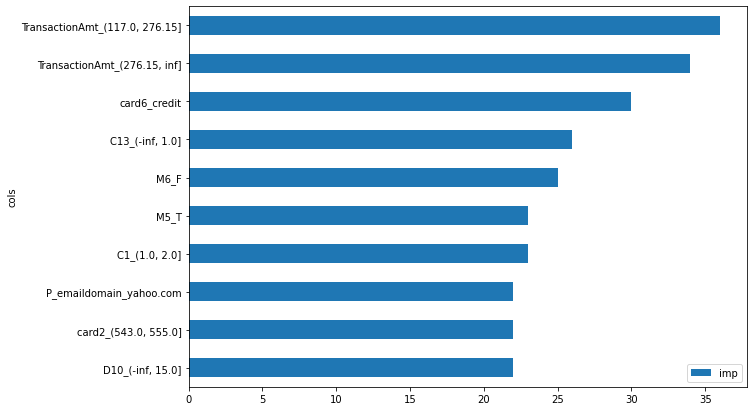

In [44]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model5.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_10 = fi[0:10]
top_10 = top_10.sort_values('imp', ascending=True)
# Plot the bar chart
top_10.plot(x='cols', kind='barh' , figsize=(10,7))
plt.show()

In [45]:
predicted = model5.predict(x_valid) 
results = confusion_matrix(y_valid, predicted) 

print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_valid, predicted)) 
print('Report : ')
print(classification_report(y_valid, predicted)) 

Confusion Matrix :
[[9608   24]
 [ 256  113]]
Accuracy Score : 0.972002799720028
Report : 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9632
           1       0.82      0.31      0.45       369

    accuracy                           0.97     10001
   macro avg       0.90      0.65      0.72     10001
weighted avg       0.97      0.97      0.97     10001



### Using Optuna

In [46]:
import optuna.integration.lightgbm as lgb

In [47]:
dtrain = lgb.Dataset(x_train, label=y_train)
dval = lgb.Dataset(x_valid, label=y_valid)

In [48]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

model = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=2, early_stopping_rounds=2)

[I 2020-09-29 12:22:07,027] A new study created in memory with name: no-name-5b26d972-c823-4fb2-bfce-853fe142d3c7
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.129797	valid_1's binary_logloss: 0.133645
[4]	training's binary_logloss: 0.121151	valid_1's binary_logloss: 0.127244
[6]	training's binary_logloss: 0.114893	valid_1's binary_logloss: 0.122436
[8]	training's binary_logloss: 0.109895	valid_1's binary_logloss: 0.118802
[10]	training's binary_logloss: 0.10576	valid_1's binary_logloss: 0.115958
[12]	training's binary_logloss: 0.102676	valid_1's binary_logloss: 0.113644
[14]	training's binary_logloss: 0.0997022	valid_1's binary_logloss: 0.11152
[16]	training's binary_logloss: 0.0970673	valid_1's binary_logloss: 0.10995
[18]	training's binary_logloss: 0.0949698	valid_1's binary_logloss: 0.108997
[20]	training's binary_logloss: 0.0929268	valid_1's binary_logloss: 0.107749
[22]	training's binary_logloss: 0.0909968	valid_1's binary_logloss: 0.106939
[24]	training's binary_logloss: 0.0892666	valid_1's binary_logloss: 0.105675
[26]	training's binary_loglos

feature_fraction, val_score: 0.100628:  14%|7    | 1/7 [00:08<00:50,  8.34s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.12957	valid_1's binary_logloss: 0.133867
[4]	training's binary_logloss: 0.120638	valid_1's binary_logloss: 0.127482
[6]	training's binary_logloss: 0.113939	valid_1's binary_logloss: 0.12213
[8]	training's binary_logloss: 0.109076	valid_1's binary_logloss: 0.118334
[10]	training's binary_logloss: 0.105107	valid_1's binary_logloss: 0.115355
[12]	training's binary_logloss: 0.101801	valid_1's binary_logloss: 0.112837
[14]	training's binary_logloss: 0.0989727	valid_1's binary_logloss: 0.11141
[16]	training's binary_logloss: 0.0967636	valid_1's binary_logloss: 0.110226
[18]	training's binary_logloss: 0.0944713	valid_1's binary_logloss: 0.108824
[20]	training's binary_logloss: 0.0923494	valid_1's binary_logloss: 0.107359
[22]	training's binary_logloss: 0.0903752	valid_1's binary_logloss: 0.106479
[24]	training's binary_logloss: 0.0884945	valid_1's binary_logloss: 0.105424
[26]	training's binary_loglos

feature_fraction, val_score: 0.099257:  29%|#4   | 2/7 [00:13<00:37,  7.51s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.128491	valid_1's binary_logloss: 0.133686
[4]	training's binary_logloss: 0.119889	valid_1's binary_logloss: 0.126554
[6]	training's binary_logloss: 0.113192	valid_1's binary_logloss: 0.121266
[8]	training's binary_logloss: 0.10836	valid_1's binary_logloss: 0.117521
[10]	training's binary_logloss: 0.104527	valid_1's binary_logloss: 0.114785
[12]	training's binary_logloss: 0.100979	valid_1's binary_logloss: 0.11249
[14]	training's binary_logloss: 0.0979809	valid_1's binary_logloss: 0.110527
[16]	training's binary_logloss: 0.0955783	valid_1's binary_logloss: 0.109289
[18]	training's binary_logloss: 0.0934975	valid_1's binary_logloss: 0.108061
[20]	training's binary_logloss: 0.0914003	valid_1's binary_logloss: 0.10675
[22]	training's binary_logloss: 0.0893667	valid_1's binary_logloss: 0.105533
[24]	training's binary_logloss: 0.0877202	valid_1's binary_logloss: 0.104719
[26]	training's binary_loglos

feature_fraction, val_score: 0.098753:  43%|##1  | 3/7 [00:19<00:27,  6.95s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.130956	valid_1's binary_logloss: 0.132861
[4]	training's binary_logloss: 0.121952	valid_1's binary_logloss: 0.126065
[6]	training's binary_logloss: 0.115727	valid_1's binary_logloss: 0.121278
[8]	training's binary_logloss: 0.110855	valid_1's binary_logloss: 0.117975
[10]	training's binary_logloss: 0.106866	valid_1's binary_logloss: 0.115434
[12]	training's binary_logloss: 0.103721	valid_1's binary_logloss: 0.113208
[14]	training's binary_logloss: 0.100734	valid_1's binary_logloss: 0.110883
[16]	training's binary_logloss: 0.0981651	valid_1's binary_logloss: 0.109482
[18]	training's binary_logloss: 0.0959017	valid_1's binary_logloss: 0.108205
[20]	training's binary_logloss: 0.0939181	valid_1's binary_logloss: 0.107481
[22]	training's binary_logloss: 0.0920976	valid_1's binary_logloss: 0.106439
[24]	training's binary_logloss: 0.0903334	valid_1's binary_logloss: 0.105483
[26]	training's binary_logl

feature_fraction, val_score: 0.098753:  57%|##8  | 4/7 [00:24<00:18,  6.32s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.129951	valid_1's binary_logloss: 0.133376
[4]	training's binary_logloss: 0.121179	valid_1's binary_logloss: 0.126295
[6]	training's binary_logloss: 0.11492	valid_1's binary_logloss: 0.121829
[8]	training's binary_logloss: 0.109899	valid_1's binary_logloss: 0.118296
[10]	training's binary_logloss: 0.105928	valid_1's binary_logloss: 0.115372
[12]	training's binary_logloss: 0.102591	valid_1's binary_logloss: 0.113043
[14]	training's binary_logloss: 0.0996781	valid_1's binary_logloss: 0.111075
[16]	training's binary_logloss: 0.0971182	valid_1's binary_logloss: 0.109564
[18]	training's binary_logloss: 0.0947926	valid_1's binary_logloss: 0.108088
[20]	training's binary_logloss: 0.0928146	valid_1's binary_logloss: 0.106904
[22]	training's binary_logloss: 0.0908635	valid_1's binary_logloss: 0.10625
[24]	training's binary_logloss: 0.0890829	valid_1's binary_logloss: 0.105376
[26]	training's binary_loglo

feature_fraction, val_score: 0.098753:  71%|###5 | 5/7 [00:29<00:11,  5.93s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.131138	valid_1's binary_logloss: 0.133922
[4]	training's binary_logloss: 0.122127	valid_1's binary_logloss: 0.126634
[6]	training's binary_logloss: 0.115816	valid_1's binary_logloss: 0.121504
[8]	training's binary_logloss: 0.111018	valid_1's binary_logloss: 0.11794
[10]	training's binary_logloss: 0.107109	valid_1's binary_logloss: 0.11527
[12]	training's binary_logloss: 0.104085	valid_1's binary_logloss: 0.113387
[14]	training's binary_logloss: 0.101201	valid_1's binary_logloss: 0.111637
[16]	training's binary_logloss: 0.0988131	valid_1's binary_logloss: 0.110289
[18]	training's binary_logloss: 0.0967204	valid_1's binary_logloss: 0.109251
[20]	training's binary_logloss: 0.0945115	valid_1's binary_logloss: 0.10797
[22]	training's binary_logloss: 0.0928184	valid_1's binary_logloss: 0.107091
[24]	training's binary_logloss: 0.0910954	valid_1's binary_logloss: 0.106097
[26]	training's binary_logloss

feature_fraction, val_score: 0.098753:  86%|####2| 6/7 [00:32<00:05,  5.06s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.128642	valid_1's binary_logloss: 0.13366
[4]	training's binary_logloss: 0.119868	valid_1's binary_logloss: 0.12657
[6]	training's binary_logloss: 0.11347	valid_1's binary_logloss: 0.121606
[8]	training's binary_logloss: 0.108817	valid_1's binary_logloss: 0.117812
[10]	training's binary_logloss: 0.104893	valid_1's binary_logloss: 0.114638
[12]	training's binary_logloss: 0.101621	valid_1's binary_logloss: 0.11244
[14]	training's binary_logloss: 0.0987906	valid_1's binary_logloss: 0.11083
[16]	training's binary_logloss: 0.0964986	valid_1's binary_logloss: 0.109498
[18]	training's binary_logloss: 0.0940199	valid_1's binary_logloss: 0.107872
[20]	training's binary_logloss: 0.0920173	valid_1's binary_logloss: 0.106783
[22]	training's binary_logloss: 0.0899941	valid_1's binary_logloss: 0.106002
[24]	training's binary_logloss: 0.0882883	valid_1's binary_logloss: 0.10511
[26]	training's binary_logloss: 

num_leaves, val_score: 0.098753:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.116435	valid_1's binary_logloss: 0.130593
[4]	training's binary_logloss: 0.101103	valid_1's binary_logloss: 0.122938
[6]	training's binary_logloss: 0.0898915	valid_1's binary_logloss: 0.118582
[8]	training's binary_logloss: 0.0803927	valid_1's binary_logloss: 0.114661
[10]	training's binary_logloss: 0.0725982	valid_1's binary_logloss: 0.111841
[12]	training's binary_logloss: 0.0660722	valid_1's binary_logloss: 0.109674
[14]	training's binary_logloss: 0.0602125	valid_1's binary_logloss: 0.10827
[16]	training's binary_logloss: 0.0550648	valid_1's binary_logloss: 0.106994
[18]	training's binary_logloss: 0.0505144	valid_1's binary_logloss: 0.106131
[20]	training's binary_logloss: 0.0464947	valid_1's binary_logloss: 0.105345
[22]	training's binary_logloss: 0.0429244	valid_1's binary_logloss: 0.10512
[24]	training's binary_logloss: 0.0396424	valid_1's binary_logloss: 0.104726
[26]	training's binary_l

num_leaves, val_score: 0.098753:   5%|5         | 1/20 [00:06<02:02,  6.45s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.122521	valid_1's binary_logloss: 0.131769
[4]	training's binary_logloss: 0.11077	valid_1's binary_logloss: 0.124999
[6]	training's binary_logloss: 0.102365	valid_1's binary_logloss: 0.120073
[8]	training's binary_logloss: 0.0959598	valid_1's binary_logloss: 0.116199
[10]	training's binary_logloss: 0.0905957	valid_1's binary_logloss: 0.113207
[12]	training's binary_logloss: 0.0859199	valid_1's binary_logloss: 0.110654
[14]	training's binary_logloss: 0.081666	valid_1's binary_logloss: 0.109252
[16]	training's binary_logloss: 0.0780096	valid_1's binary_logloss: 0.10783
[18]	training's binary_logloss: 0.0742163	valid_1's binary_logloss: 0.106293
[20]	training's binary_logloss: 0.0712564	valid_1's binary_logloss: 0.105395
[22]	training's binary_logloss: 0.0684165	valid_1's binary_logloss: 0.104572
[24]	training's binary_logloss: 0.0659676	valid_1's binary_logloss: 0.104105
[26]	training's binary_log

num_leaves, val_score: 0.098753:  10%|#         | 2/20 [00:11<01:46,  5.91s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.12047	valid_1's binary_logloss: 0.131301
[4]	training's binary_logloss: 0.108378	valid_1's binary_logloss: 0.123969
[6]	training's binary_logloss: 0.0990179	valid_1's binary_logloss: 0.119146
[8]	training's binary_logloss: 0.0917869	valid_1's binary_logloss: 0.115094
[10]	training's binary_logloss: 0.0860351	valid_1's binary_logloss: 0.111655
[12]	training's binary_logloss: 0.0808093	valid_1's binary_logloss: 0.109382
[14]	training's binary_logloss: 0.076208	valid_1's binary_logloss: 0.10744
[16]	training's binary_logloss: 0.0720544	valid_1's binary_logloss: 0.106217
[18]	training's binary_logloss: 0.0681615	valid_1's binary_logloss: 0.105153
[20]	training's binary_logloss: 0.0647175	valid_1's binary_logloss: 0.104203
[22]	training's binary_logloss: 0.061555	valid_1's binary_logloss: 0.103459
[24]	training's binary_logloss: 0.0586579	valid_1's binary_logloss: 0.103071
[26]	training's binary_log

num_leaves, val_score: 0.098753:  15%|#5        | 3/20 [00:15<01:33,  5.48s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.116247	valid_1's binary_logloss: 0.130495
[4]	training's binary_logloss: 0.10071	valid_1's binary_logloss: 0.123034
[6]	training's binary_logloss: 0.0891503	valid_1's binary_logloss: 0.118655
[8]	training's binary_logloss: 0.0796436	valid_1's binary_logloss: 0.114565
[10]	training's binary_logloss: 0.0716259	valid_1's binary_logloss: 0.111389
[12]	training's binary_logloss: 0.0649469	valid_1's binary_logloss: 0.109061
[14]	training's binary_logloss: 0.0591685	valid_1's binary_logloss: 0.107657
[16]	training's binary_logloss: 0.0540088	valid_1's binary_logloss: 0.106499
[18]	training's binary_logloss: 0.0495438	valid_1's binary_logloss: 0.105551
[20]	training's binary_logloss: 0.0454284	valid_1's binary_logloss: 0.104554
[22]	training's binary_logloss: 0.0417023	valid_1's binary_logloss: 0.103721
[24]	training's binary_logloss: 0.0383912	valid_1's binary_logloss: 0.103149
[26]	training's binary_

num_leaves, val_score: 0.098753:  20%|##        | 4/20 [00:23<01:39,  6.24s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.14348	valid_1's binary_logloss: 0.142717
[4]	training's binary_logloss: 0.138085	valid_1's binary_logloss: 0.137762
[6]	training's binary_logloss: 0.134309	valid_1's binary_logloss: 0.134218
[8]	training's binary_logloss: 0.131413	valid_1's binary_logloss: 0.131787
[10]	training's binary_logloss: 0.128831	valid_1's binary_logloss: 0.12928
[12]	training's binary_logloss: 0.126877	valid_1's binary_logloss: 0.127311
[14]	training's binary_logloss: 0.125343	valid_1's binary_logloss: 0.125806
[16]	training's binary_logloss: 0.123979	valid_1's binary_logloss: 0.124324
[18]	training's binary_logloss: 0.122848	valid_1's binary_logloss: 0.123079
[20]	training's binary_logloss: 0.122	valid_1's binary_logloss: 0.122211
[22]	training's binary_logloss: 0.12112	valid_1's binary_logloss: 0.121269
[24]	training's binary_logloss: 0.120301	valid_1's binary_logloss: 0.120567
[26]	training's binary_logloss: 0.1196

num_leaves, val_score: 0.098753:  25%|##5       | 5/20 [00:29<01:30,  6.03s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.14602	valid_1's binary_logloss: 0.144702
[4]	training's binary_logloss: 0.141623	valid_1's binary_logloss: 0.140612
[6]	training's binary_logloss: 0.138929	valid_1's binary_logloss: 0.137995
[8]	training's binary_logloss: 0.136922	valid_1's binary_logloss: 0.135953
[10]	training's binary_logloss: 0.135242	valid_1's binary_logloss: 0.13425
[12]	training's binary_logloss: 0.133848	valid_1's binary_logloss: 0.132907
[14]	training's binary_logloss: 0.132635	valid_1's binary_logloss: 0.131709
[16]	training's binary_logloss: 0.131548	valid_1's binary_logloss: 0.13062
[18]	training's binary_logloss: 0.1306	valid_1's binary_logloss: 0.129589
[20]	training's binary_logloss: 0.129757	valid_1's binary_logloss: 0.128737
[22]	training's binary_logloss: 0.128993	valid_1's binary_logloss: 0.127921
[24]	training's binary_logloss: 0.128314	valid_1's binary_logloss: 0.127199
[26]	training's binary_logloss: 0.127

num_leaves, val_score: 0.098753:  30%|###       | 6/20 [00:39<01:42,  7.32s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.117936	valid_1's binary_logloss: 0.130889
[4]	training's binary_logloss: 0.103808	valid_1's binary_logloss: 0.12351
[6]	training's binary_logloss: 0.0932588	valid_1's binary_logloss: 0.118812
[8]	training's binary_logloss: 0.0847292	valid_1's binary_logloss: 0.114797
[10]	training's binary_logloss: 0.0777852	valid_1's binary_logloss: 0.111614
[12]	training's binary_logloss: 0.0718371	valid_1's binary_logloss: 0.109463
[14]	training's binary_logloss: 0.0666515	valid_1's binary_logloss: 0.107942
[16]	training's binary_logloss: 0.0617102	valid_1's binary_logloss: 0.10651
[18]	training's binary_logloss: 0.0574425	valid_1's binary_logloss: 0.105515
[20]	training's binary_logloss: 0.0535715	valid_1's binary_logloss: 0.104828
[22]	training's binary_logloss: 0.0499851	valid_1's binary_logloss: 0.104203
[24]	training's binary_logloss: 0.0467952	valid_1's binary_logloss: 0.10363
[26]	training's binary_lo

num_leaves, val_score: 0.098753:  35%|###5      | 7/20 [00:44<01:27,  6.70s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125393	valid_1's binary_logloss: 0.132404
[4]	training's binary_logloss: 0.115239	valid_1's binary_logloss: 0.125599
[6]	training's binary_logloss: 0.107747	valid_1's binary_logloss: 0.120268
[8]	training's binary_logloss: 0.102089	valid_1's binary_logloss: 0.11653
[10]	training's binary_logloss: 0.0971732	valid_1's binary_logloss: 0.113765
[12]	training's binary_logloss: 0.0932217	valid_1's binary_logloss: 0.111333
[14]	training's binary_logloss: 0.0898247	valid_1's binary_logloss: 0.109693
[16]	training's binary_logloss: 0.0869956	valid_1's binary_logloss: 0.108299
[18]	training's binary_logloss: 0.0842668	valid_1's binary_logloss: 0.107277
[20]	training's binary_logloss: 0.0814157	valid_1's binary_logloss: 0.105943
[22]	training's binary_logloss: 0.0787748	valid_1's binary_logloss: 0.104845
[24]	training's binary_logloss: 0.0764321	valid_1's binary_logloss: 0.104147
[26]	training's binary_lo

num_leaves, val_score: 0.098494:  40%|####      | 8/20 [00:49<01:13,  6.13s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.124634	valid_1's binary_logloss: 0.132119
[4]	training's binary_logloss: 0.114212	valid_1's binary_logloss: 0.125417
[6]	training's binary_logloss: 0.106422	valid_1's binary_logloss: 0.119791
[8]	training's binary_logloss: 0.100413	valid_1's binary_logloss: 0.116167
[10]	training's binary_logloss: 0.0955846	valid_1's binary_logloss: 0.113194
[12]	training's binary_logloss: 0.0916405	valid_1's binary_logloss: 0.11098
[14]	training's binary_logloss: 0.0879906	valid_1's binary_logloss: 0.109325
[16]	training's binary_logloss: 0.0847987	valid_1's binary_logloss: 0.108027
[18]	training's binary_logloss: 0.0817535	valid_1's binary_logloss: 0.107106
[20]	training's binary_logloss: 0.0789171	valid_1's binary_logloss: 0.106092
[22]	training's binary_logloss: 0.0762993	valid_1's binary_logloss: 0.105223
[24]	training's binary_logloss: 0.0738678	valid_1's binary_logloss: 0.104375
[26]	training's binary_lo

num_leaves, val_score: 0.098494:  45%|####5     | 9/20 [00:54<01:04,  5.90s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.12741	valid_1's binary_logloss: 0.133456
[4]	training's binary_logloss: 0.118225	valid_1's binary_logloss: 0.126584
[6]	training's binary_logloss: 0.111394	valid_1's binary_logloss: 0.12115
[8]	training's binary_logloss: 0.106385	valid_1's binary_logloss: 0.117529
[10]	training's binary_logloss: 0.102145	valid_1's binary_logloss: 0.114192
[12]	training's binary_logloss: 0.0984986	valid_1's binary_logloss: 0.111785
[14]	training's binary_logloss: 0.0956753	valid_1's binary_logloss: 0.110105
[16]	training's binary_logloss: 0.0931316	valid_1's binary_logloss: 0.109033
[18]	training's binary_logloss: 0.0907075	valid_1's binary_logloss: 0.107891
[20]	training's binary_logloss: 0.0881666	valid_1's binary_logloss: 0.107088
[22]	training's binary_logloss: 0.0858699	valid_1's binary_logloss: 0.10609
[24]	training's binary_logloss: 0.0840974	valid_1's binary_logloss: 0.105409
[26]	training's binary_loglo

num_leaves, val_score: 0.098494:  50%|####5    | 10/20 [00:59<00:54,  5.46s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.11894	valid_1's binary_logloss: 0.131112
[4]	training's binary_logloss: 0.105706	valid_1's binary_logloss: 0.123775
[6]	training's binary_logloss: 0.0955625	valid_1's binary_logloss: 0.118891
[8]	training's binary_logloss: 0.0875565	valid_1's binary_logloss: 0.115142
[10]	training's binary_logloss: 0.0809438	valid_1's binary_logloss: 0.112259
[12]	training's binary_logloss: 0.0753255	valid_1's binary_logloss: 0.109555
[14]	training's binary_logloss: 0.0703208	valid_1's binary_logloss: 0.107861
[16]	training's binary_logloss: 0.0656894	valid_1's binary_logloss: 0.106778
[18]	training's binary_logloss: 0.0616918	valid_1's binary_logloss: 0.105878
[20]	training's binary_logloss: 0.0579539	valid_1's binary_logloss: 0.104926
[22]	training's binary_logloss: 0.0546453	valid_1's binary_logloss: 0.104449
[24]	training's binary_logloss: 0.0516386	valid_1's binary_logloss: 0.103992
[26]	training's binary_

num_leaves, val_score: 0.098494:  55%|####9    | 11/20 [01:03<00:46,  5.12s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.117916	valid_1's binary_logloss: 0.130888
[4]	training's binary_logloss: 0.103787	valid_1's binary_logloss: 0.123537
[6]	training's binary_logloss: 0.0931639	valid_1's binary_logloss: 0.118778
[8]	training's binary_logloss: 0.0845736	valid_1's binary_logloss: 0.115204
[10]	training's binary_logloss: 0.0776883	valid_1's binary_logloss: 0.112379
[12]	training's binary_logloss: 0.0716863	valid_1's binary_logloss: 0.110012
[14]	training's binary_logloss: 0.0664068	valid_1's binary_logloss: 0.108553
[16]	training's binary_logloss: 0.0616722	valid_1's binary_logloss: 0.107196
[18]	training's binary_logloss: 0.0573199	valid_1's binary_logloss: 0.106484
[20]	training's binary_logloss: 0.0533573	valid_1's binary_logloss: 0.105382
[22]	training's binary_logloss: 0.0499409	valid_1's binary_logloss: 0.10479
[24]	training's binary_logloss: 0.0465706	valid_1's binary_logloss: 0.103894
[26]	training's binary_

num_leaves, val_score: 0.098494:  60%|#####3   | 12/20 [01:08<00:41,  5.16s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125267	valid_1's binary_logloss: 0.132384
[4]	training's binary_logloss: 0.115081	valid_1's binary_logloss: 0.12559
[6]	training's binary_logloss: 0.107627	valid_1's binary_logloss: 0.120453
[8]	training's binary_logloss: 0.101969	valid_1's binary_logloss: 0.116465
[10]	training's binary_logloss: 0.0971941	valid_1's binary_logloss: 0.113581
[12]	training's binary_logloss: 0.093115	valid_1's binary_logloss: 0.110853
[14]	training's binary_logloss: 0.0897096	valid_1's binary_logloss: 0.109159
[16]	training's binary_logloss: 0.0866494	valid_1's binary_logloss: 0.107383
[18]	training's binary_logloss: 0.0839164	valid_1's binary_logloss: 0.106121
[20]	training's binary_logloss: 0.0812072	valid_1's binary_logloss: 0.105037
[22]	training's binary_logloss: 0.0785051	valid_1's binary_logloss: 0.104285
[24]	training's binary_logloss: 0.0761164	valid_1's binary_logloss: 0.103399
[26]	training's binary_log

num_leaves, val_score: 0.098223:  65%|#####8   | 13/20 [01:14<00:36,  5.18s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.127325	valid_1's binary_logloss: 0.133685
[4]	training's binary_logloss: 0.11819	valid_1's binary_logloss: 0.126515
[6]	training's binary_logloss: 0.111487	valid_1's binary_logloss: 0.121428
[8]	training's binary_logloss: 0.10627	valid_1's binary_logloss: 0.118127
[10]	training's binary_logloss: 0.102135	valid_1's binary_logloss: 0.115457
[12]	training's binary_logloss: 0.0984434	valid_1's binary_logloss: 0.11307
[14]	training's binary_logloss: 0.095611	valid_1's binary_logloss: 0.111285
[16]	training's binary_logloss: 0.0927971	valid_1's binary_logloss: 0.109598
[18]	training's binary_logloss: 0.0903164	valid_1's binary_logloss: 0.108312
[20]	training's binary_logloss: 0.0879548	valid_1's binary_logloss: 0.107253
[22]	training's binary_logloss: 0.0860357	valid_1's binary_logloss: 0.106622
[24]	training's binary_logloss: 0.0839888	valid_1's binary_logloss: 0.105853
[26]	training's binary_loglos

num_leaves, val_score: 0.098223:  70%|######3  | 14/20 [01:20<00:33,  5.55s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.122967	valid_1's binary_logloss: 0.131969
[4]	training's binary_logloss: 0.11162	valid_1's binary_logloss: 0.125111
[6]	training's binary_logloss: 0.103421	valid_1's binary_logloss: 0.119948
[8]	training's binary_logloss: 0.097002	valid_1's binary_logloss: 0.116121
[10]	training's binary_logloss: 0.0916922	valid_1's binary_logloss: 0.113086
[12]	training's binary_logloss: 0.0870745	valid_1's binary_logloss: 0.110612
[14]	training's binary_logloss: 0.0828833	valid_1's binary_logloss: 0.108711
[16]	training's binary_logloss: 0.0792178	valid_1's binary_logloss: 0.10733
[18]	training's binary_logloss: 0.0758186	valid_1's binary_logloss: 0.1063
[20]	training's binary_logloss: 0.0727149	valid_1's binary_logloss: 0.10517
[22]	training's binary_logloss: 0.070078	valid_1's binary_logloss: 0.104174
[24]	training's binary_logloss: 0.0674598	valid_1's binary_logloss: 0.103341
[26]	training's binary_logloss

num_leaves, val_score: 0.098223:  75%|######7  | 15/20 [01:24<00:25,  5.14s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.120376	valid_1's binary_logloss: 0.131353
[4]	training's binary_logloss: 0.108056	valid_1's binary_logloss: 0.124214
[6]	training's binary_logloss: 0.0988864	valid_1's binary_logloss: 0.119347
[8]	training's binary_logloss: 0.0916261	valid_1's binary_logloss: 0.115033
[10]	training's binary_logloss: 0.0855371	valid_1's binary_logloss: 0.111856
[12]	training's binary_logloss: 0.0803823	valid_1's binary_logloss: 0.109367
[14]	training's binary_logloss: 0.0755886	valid_1's binary_logloss: 0.107679
[16]	training's binary_logloss: 0.0714255	valid_1's binary_logloss: 0.106344
[18]	training's binary_logloss: 0.0679317	valid_1's binary_logloss: 0.105473
[20]	training's binary_logloss: 0.0646325	valid_1's binary_logloss: 0.104748
[22]	training's binary_logloss: 0.0615017	valid_1's binary_logloss: 0.10407
[24]	training's binary_logloss: 0.0585578	valid_1's binary_logloss: 0.10358
[26]	training's binary_l

num_leaves, val_score: 0.098223:  80%|#######2 | 16/20 [01:30<00:21,  5.47s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.130111	valid_1's binary_logloss: 0.134214
[4]	training's binary_logloss: 0.12168	valid_1's binary_logloss: 0.127284
[6]	training's binary_logloss: 0.115421	valid_1's binary_logloss: 0.12209
[8]	training's binary_logloss: 0.11094	valid_1's binary_logloss: 0.118329
[10]	training's binary_logloss: 0.107414	valid_1's binary_logloss: 0.115316
[12]	training's binary_logloss: 0.104187	valid_1's binary_logloss: 0.113081
[14]	training's binary_logloss: 0.101478	valid_1's binary_logloss: 0.111324
[16]	training's binary_logloss: 0.0993708	valid_1's binary_logloss: 0.110037
[18]	training's binary_logloss: 0.0973155	valid_1's binary_logloss: 0.108706
[20]	training's binary_logloss: 0.0953461	valid_1's binary_logloss: 0.107509
[22]	training's binary_logloss: 0.0936565	valid_1's binary_logloss: 0.106794
[24]	training's binary_logloss: 0.0922461	valid_1's binary_logloss: 0.106103
[26]	training's binary_logloss

num_leaves, val_score: 0.098223:  85%|#######6 | 17/20 [01:35<00:15,  5.26s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.123658	valid_1's binary_logloss: 0.13191
[4]	training's binary_logloss: 0.112931	valid_1's binary_logloss: 0.124931
[6]	training's binary_logloss: 0.10493	valid_1's binary_logloss: 0.119819
[8]	training's binary_logloss: 0.0990673	valid_1's binary_logloss: 0.116128
[10]	training's binary_logloss: 0.0940402	valid_1's binary_logloss: 0.113113
[12]	training's binary_logloss: 0.0894999	valid_1's binary_logloss: 0.110924
[14]	training's binary_logloss: 0.0856825	valid_1's binary_logloss: 0.109117
[16]	training's binary_logloss: 0.0819858	valid_1's binary_logloss: 0.107309
[18]	training's binary_logloss: 0.0790031	valid_1's binary_logloss: 0.106001
[20]	training's binary_logloss: 0.0762284	valid_1's binary_logloss: 0.105165
[22]	training's binary_logloss: 0.0734577	valid_1's binary_logloss: 0.104432
[24]	training's binary_logloss: 0.0711059	valid_1's binary_logloss: 0.103694
[26]	training's binary_lo

num_leaves, val_score: 0.098223:  90%|########1| 18/20 [01:41<00:10,  5.30s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.119646	valid_1's binary_logloss: 0.131182
[4]	training's binary_logloss: 0.106647	valid_1's binary_logloss: 0.124022
[6]	training's binary_logloss: 0.0969482	valid_1's binary_logloss: 0.119346
[8]	training's binary_logloss: 0.0892219	valid_1's binary_logloss: 0.115361
[10]	training's binary_logloss: 0.0829483	valid_1's binary_logloss: 0.112476
[12]	training's binary_logloss: 0.0776842	valid_1's binary_logloss: 0.110056
[14]	training's binary_logloss: 0.0729823	valid_1's binary_logloss: 0.108308
[16]	training's binary_logloss: 0.0687468	valid_1's binary_logloss: 0.106852
[18]	training's binary_logloss: 0.0646593	valid_1's binary_logloss: 0.105658
[20]	training's binary_logloss: 0.0611129	valid_1's binary_logloss: 0.104741
[22]	training's binary_logloss: 0.0578578	valid_1's binary_logloss: 0.103938
[24]	training's binary_logloss: 0.0548047	valid_1's binary_logloss: 0.103279
[26]	training's binary

num_leaves, val_score: 0.098223:  95%|########5| 19/20 [01:45<00:05,  5.00s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.121972	valid_1's binary_logloss: 0.131664
[4]	training's binary_logloss: 0.11018	valid_1's binary_logloss: 0.124652
[6]	training's binary_logloss: 0.101442	valid_1's binary_logloss: 0.119732
[8]	training's binary_logloss: 0.0948363	valid_1's binary_logloss: 0.115483
[10]	training's binary_logloss: 0.0893202	valid_1's binary_logloss: 0.112373
[12]	training's binary_logloss: 0.0846115	valid_1's binary_logloss: 0.109639
[14]	training's binary_logloss: 0.0802877	valid_1's binary_logloss: 0.108031
[16]	training's binary_logloss: 0.0763768	valid_1's binary_logloss: 0.106379
[18]	training's binary_logloss: 0.0726845	valid_1's binary_logloss: 0.105207
[20]	training's binary_logloss: 0.0694507	valid_1's binary_logloss: 0.104109
[22]	training's binary_logloss: 0.0666195	valid_1's binary_logloss: 0.103446
[24]	training's binary_logloss: 0.0638743	valid_1's binary_logloss: 0.102735
[26]	training's binary_l

bagging, val_score: 0.098223:   0%|                     | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.129724	valid_1's binary_logloss: 0.133172
[4]	training's binary_logloss: 0.119176	valid_1's binary_logloss: 0.125531
[6]	training's binary_logloss: 0.111474	valid_1's binary_logloss: 0.120055
[8]	training's binary_logloss: 0.106043	valid_1's binary_logloss: 0.116437
[10]	training's binary_logloss: 0.10143	valid_1's binary_logloss: 0.114345
[12]	training's binary_logloss: 0.0975686	valid_1's binary_logloss: 0.112138
[14]	training's binary_logloss: 0.0937635	valid_1's binary_logloss: 0.11043
[16]	training's binary_logloss: 0.0906651	valid_1's binary_logloss: 0.109354
[18]	training's binary_logloss: 0.0880457	valid_1's binary_logloss: 0.108243
[20]	training's binary_logloss: 0.0856137	valid_1's binary_logloss: 0.107315
[22]	training's binary_logloss: 0.0832459	valid_1's binary_logloss: 0.106373
[24]	training's binary_logloss: 0.0809831	valid_1's binary_logloss: 0.10589
[26]	training's binary_loglo

bagging, val_score: 0.098223:  10%|#3           | 1/10 [00:03<00:30,  3.37s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125038	valid_1's binary_logloss: 0.132399
[4]	training's binary_logloss: 0.114827	valid_1's binary_logloss: 0.125834
[6]	training's binary_logloss: 0.107143	valid_1's binary_logloss: 0.120538
[8]	training's binary_logloss: 0.101516	valid_1's binary_logloss: 0.116662
[10]	training's binary_logloss: 0.0968672	valid_1's binary_logloss: 0.113898
[12]	training's binary_logloss: 0.0926258	valid_1's binary_logloss: 0.111491
[14]	training's binary_logloss: 0.0892932	valid_1's binary_logloss: 0.109599
[16]	training's binary_logloss: 0.085962	valid_1's binary_logloss: 0.108233
[18]	training's binary_logloss: 0.0831095	valid_1's binary_logloss: 0.106772
[20]	training's binary_logloss: 0.0804129	valid_1's binary_logloss: 0.105635
[22]	training's binary_logloss: 0.0779053	valid_1's binary_logloss: 0.104434
[24]	training's binary_logloss: 0.075811	valid_1's binary_logloss: 0.103566
[26]	training's binary_log

bagging, val_score: 0.098223:  20%|##6          | 2/10 [00:07<00:29,  3.70s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125434	valid_1's binary_logloss: 0.131058
[4]	training's binary_logloss: 0.1157	valid_1's binary_logloss: 0.124221
[6]	training's binary_logloss: 0.108574	valid_1's binary_logloss: 0.11871
[8]	training's binary_logloss: 0.102782	valid_1's binary_logloss: 0.114941
[10]	training's binary_logloss: 0.0977652	valid_1's binary_logloss: 0.112178
[12]	training's binary_logloss: 0.0937093	valid_1's binary_logloss: 0.109756
[14]	training's binary_logloss: 0.0905237	valid_1's binary_logloss: 0.107881
[16]	training's binary_logloss: 0.0871627	valid_1's binary_logloss: 0.106176
[18]	training's binary_logloss: 0.0844741	valid_1's binary_logloss: 0.10539
[20]	training's binary_logloss: 0.0819351	valid_1's binary_logloss: 0.104519
[22]	training's binary_logloss: 0.0795126	valid_1's binary_logloss: 0.103923
[24]	training's binary_logloss: 0.0769742	valid_1's binary_logloss: 0.103416
[26]	training's binary_loglo

bagging, val_score: 0.098223:  30%|###9         | 3/10 [00:12<00:28,  4.06s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.129265	valid_1's binary_logloss: 0.133008
[4]	training's binary_logloss: 0.118263	valid_1's binary_logloss: 0.125513
[6]	training's binary_logloss: 0.110964	valid_1's binary_logloss: 0.120491
[8]	training's binary_logloss: 0.105102	valid_1's binary_logloss: 0.116694
[10]	training's binary_logloss: 0.100386	valid_1's binary_logloss: 0.113674
[12]	training's binary_logloss: 0.0962768	valid_1's binary_logloss: 0.111368
[14]	training's binary_logloss: 0.0926919	valid_1's binary_logloss: 0.10979
[16]	training's binary_logloss: 0.0895418	valid_1's binary_logloss: 0.108498
[18]	training's binary_logloss: 0.0868969	valid_1's binary_logloss: 0.107287
[20]	training's binary_logloss: 0.0843575	valid_1's binary_logloss: 0.106266
[22]	training's binary_logloss: 0.0817429	valid_1's binary_logloss: 0.10555
[24]	training's binary_logloss: 0.079394	valid_1's binary_logloss: 0.104617
[26]	training's binary_loglo

bagging, val_score: 0.098223:  40%|#####2       | 4/10 [00:16<00:23,  3.86s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.127473	valid_1's binary_logloss: 0.131959
[4]	training's binary_logloss: 0.117446	valid_1's binary_logloss: 0.12446
[6]	training's binary_logloss: 0.110022	valid_1's binary_logloss: 0.120114
[8]	training's binary_logloss: 0.104286	valid_1's binary_logloss: 0.116943
[10]	training's binary_logloss: 0.0991939	valid_1's binary_logloss: 0.114322
[12]	training's binary_logloss: 0.0952024	valid_1's binary_logloss: 0.112583
[14]	training's binary_logloss: 0.0912659	valid_1's binary_logloss: 0.111152
[16]	training's binary_logloss: 0.0883259	valid_1's binary_logloss: 0.10991
[18]	training's binary_logloss: 0.0855292	valid_1's binary_logloss: 0.108506
[20]	training's binary_logloss: 0.0831806	valid_1's binary_logloss: 0.107679
[22]	training's binary_logloss: 0.0806729	valid_1's binary_logloss: 0.107071
[24]	training's binary_logloss: 0.078464	valid_1's binary_logloss: 0.106444
[26]	training's binary_logl

bagging, val_score: 0.098223:  50%|######5      | 5/10 [00:19<00:18,  3.64s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125026	valid_1's binary_logloss: 0.132379
[4]	training's binary_logloss: 0.114794	valid_1's binary_logloss: 0.125829
[6]	training's binary_logloss: 0.107326	valid_1's binary_logloss: 0.120667
[8]	training's binary_logloss: 0.101675	valid_1's binary_logloss: 0.116814
[10]	training's binary_logloss: 0.0968544	valid_1's binary_logloss: 0.114115
[12]	training's binary_logloss: 0.0927936	valid_1's binary_logloss: 0.111713
[14]	training's binary_logloss: 0.08922	valid_1's binary_logloss: 0.109746
[16]	training's binary_logloss: 0.0860683	valid_1's binary_logloss: 0.108427
[18]	training's binary_logloss: 0.0834009	valid_1's binary_logloss: 0.106912
[20]	training's binary_logloss: 0.0807839	valid_1's binary_logloss: 0.105606
[22]	training's binary_logloss: 0.0781253	valid_1's binary_logloss: 0.104755
[24]	training's binary_logloss: 0.0757224	valid_1's binary_logloss: 0.103955
[26]	training's binary_log

bagging, val_score: 0.098223:  60%|#######8     | 6/10 [00:24<00:16,  4.05s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125263	valid_1's binary_logloss: 0.132379
[4]	training's binary_logloss: 0.115062	valid_1's binary_logloss: 0.125603
[6]	training's binary_logloss: 0.107566	valid_1's binary_logloss: 0.120182
[8]	training's binary_logloss: 0.101797	valid_1's binary_logloss: 0.116413
[10]	training's binary_logloss: 0.0969853	valid_1's binary_logloss: 0.11342
[12]	training's binary_logloss: 0.0930729	valid_1's binary_logloss: 0.111006
[14]	training's binary_logloss: 0.0893176	valid_1's binary_logloss: 0.108927
[16]	training's binary_logloss: 0.086229	valid_1's binary_logloss: 0.107606
[18]	training's binary_logloss: 0.0829494	valid_1's binary_logloss: 0.106409
[20]	training's binary_logloss: 0.08021	valid_1's binary_logloss: 0.105509
[22]	training's binary_logloss: 0.0778843	valid_1's binary_logloss: 0.104272
[24]	training's binary_logloss: 0.075656	valid_1's binary_logloss: 0.103743
[26]	training's binary_loglos

bagging, val_score: 0.098223:  70%|#########1   | 7/10 [00:30<00:14,  4.78s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125066	valid_1's binary_logloss: 0.13248
[4]	training's binary_logloss: 0.11474	valid_1's binary_logloss: 0.125314
[6]	training's binary_logloss: 0.107286	valid_1's binary_logloss: 0.120175
[8]	training's binary_logloss: 0.101718	valid_1's binary_logloss: 0.116408
[10]	training's binary_logloss: 0.0968453	valid_1's binary_logloss: 0.113789
[12]	training's binary_logloss: 0.0928216	valid_1's binary_logloss: 0.111348
[14]	training's binary_logloss: 0.0893522	valid_1's binary_logloss: 0.10954
[16]	training's binary_logloss: 0.0856971	valid_1's binary_logloss: 0.107734
[18]	training's binary_logloss: 0.0829755	valid_1's binary_logloss: 0.106626
[20]	training's binary_logloss: 0.0804147	valid_1's binary_logloss: 0.105638
[22]	training's binary_logloss: 0.0778354	valid_1's binary_logloss: 0.104889
[24]	training's binary_logloss: 0.0756069	valid_1's binary_logloss: 0.104005
[26]	training's binary_logl

bagging, val_score: 0.097876:  80%|##########4  | 8/10 [00:36<00:10,  5.14s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125634	valid_1's binary_logloss: 0.131837
[4]	training's binary_logloss: 0.1154	valid_1's binary_logloss: 0.124648
[6]	training's binary_logloss: 0.108106	valid_1's binary_logloss: 0.120166
[8]	training's binary_logloss: 0.102367	valid_1's binary_logloss: 0.116423
[10]	training's binary_logloss: 0.0975182	valid_1's binary_logloss: 0.113795
[12]	training's binary_logloss: 0.0936531	valid_1's binary_logloss: 0.111563
[14]	training's binary_logloss: 0.0900165	valid_1's binary_logloss: 0.110133
[16]	training's binary_logloss: 0.0868772	valid_1's binary_logloss: 0.108571
[18]	training's binary_logloss: 0.0840492	valid_1's binary_logloss: 0.10741
[20]	training's binary_logloss: 0.0815563	valid_1's binary_logloss: 0.106457
[22]	training's binary_logloss: 0.0789808	valid_1's binary_logloss: 0.105764
[24]	training's binary_logloss: 0.0766798	valid_1's binary_logloss: 0.105132
[26]	training's binary_logl

bagging, val_score: 0.097876:  90%|###########7 | 9/10 [00:43<00:05,  5.51s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125063	valid_1's binary_logloss: 0.132348
[4]	training's binary_logloss: 0.114834	valid_1's binary_logloss: 0.125137
[6]	training's binary_logloss: 0.1074	valid_1's binary_logloss: 0.119856
[8]	training's binary_logloss: 0.101608	valid_1's binary_logloss: 0.115972
[10]	training's binary_logloss: 0.0968091	valid_1's binary_logloss: 0.113349
[12]	training's binary_logloss: 0.0927514	valid_1's binary_logloss: 0.11106
[14]	training's binary_logloss: 0.0891994	valid_1's binary_logloss: 0.109149
[16]	training's binary_logloss: 0.0859197	valid_1's binary_logloss: 0.107705
[18]	training's binary_logloss: 0.0832324	valid_1's binary_logloss: 0.106493
[20]	training's binary_logloss: 0.0804005	valid_1's binary_logloss: 0.105576
[22]	training's binary_logloss: 0.0778422	valid_1's binary_logloss: 0.105004
[24]	training's binary_logloss: 0.0757541	valid_1's binary_logloss: 0.104312
[26]	training's binary_logl

feature_fraction_stage2, val_score: 0.097876:   0%|      | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125144	valid_1's binary_logloss: 0.132317
[4]	training's binary_logloss: 0.115146	valid_1's binary_logloss: 0.125218
[6]	training's binary_logloss: 0.107692	valid_1's binary_logloss: 0.120187
[8]	training's binary_logloss: 0.101715	valid_1's binary_logloss: 0.116487
[10]	training's binary_logloss: 0.0971104	valid_1's binary_logloss: 0.113524
[12]	training's binary_logloss: 0.0933831	valid_1's binary_logloss: 0.111369
[14]	training's binary_logloss: 0.0897336	valid_1's binary_logloss: 0.109358
[16]	training's binary_logloss: 0.086522	valid_1's binary_logloss: 0.10753
[18]	training's binary_logloss: 0.08351	valid_1's binary_logloss: 0.106368
[20]	training's binary_logloss: 0.0807626	valid_1's binary_logloss: 0.105318
[22]	training's binary_logloss: 0.0784152	valid_1's binary_logloss: 0.104464
[24]	training's binary_logloss: 0.076116	valid_1's binary_logloss: 0.103851
[26]	training's binary_loglos

feature_fraction_stage2, val_score: 0.097876:  33%|3| 1/3 [00:12<00:24, 12.09s/[I 2020-09-29 12:25:37,129] Trial 37 finished with value: 0.1000134430477904 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.1000134430477904.
feature_fraction_stage2, val_score: 0.097876:  33%|3| 1/3 [00:12<00:24, 12.09s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125181	valid_1's binary_logloss: 0.132281
[4]	training's binary_logloss: 0.115249	valid_1's binary_logloss: 0.125078
[6]	training's binary_logloss: 0.10766	valid_1's binary_logloss: 0.120116
[8]	training's binary_logloss: 0.101787	valid_1's binary_logloss: 0.116379
[10]	training's binary_logloss: 0.0970545	valid_1's binary_logloss: 0.113735
[12]	training's binary_logloss: 0.0931871	valid_1's binary_logloss: 0.111653
[14]	training's binary_logloss: 0.0896145	valid_1's binary_logloss: 0.109806
[16]	training's binary_logloss: 0.0866198	valid_1's binary_logloss: 0.108512
[18]	training's binary_logloss: 0.0837478	valid_1's binary_logloss: 0.107479
[20]	training's binary_logloss: 0.0808855	valid_1's binary_logloss: 0.106601
[22]	training's binary_logloss: 0.0784625	valid_1's binary_logloss: 0.105584
[24]	training's binary_logloss: 0.0762068	valid_1's binary_logloss: 0.104997
[26]	training's binary_lo

feature_fraction_stage2, val_score: 0.097876:  67%|6| 2/3 [00:30<00:14, 14.12s/[I 2020-09-29 12:25:55,984] Trial 38 finished with value: 0.10001673895081752 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.1000134430477904.
feature_fraction_stage2, val_score: 0.097876:  67%|6| 2/3 [00:30<00:14, 14.12s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.12515	valid_1's binary_logloss: 0.132387
[4]	training's binary_logloss: 0.11518	valid_1's binary_logloss: 0.12537
[6]	training's binary_logloss: 0.107686	valid_1's binary_logloss: 0.120354
[8]	training's binary_logloss: 0.101919	valid_1's binary_logloss: 0.11699
[10]	training's binary_logloss: 0.0973332	valid_1's binary_logloss: 0.114075
[12]	training's binary_logloss: 0.0934643	valid_1's binary_logloss: 0.111926
[14]	training's binary_logloss: 0.0899128	valid_1's binary_logloss: 0.110026
[16]	training's binary_logloss: 0.0868201	valid_1's binary_logloss: 0.108319
[18]	training's binary_logloss: 0.0839603	valid_1's binary_logloss: 0.106786
[20]	training's binary_logloss: 0.0811776	valid_1's binary_logloss: 0.105678
[22]	training's binary_logloss: 0.0786975	valid_1's binary_logloss: 0.104893
[24]	training's binary_logloss: 0.0763561	valid_1's binary_logloss: 0.104125
[26]	training's binary_loglo

feature_fraction_stage2, val_score: 0.097876: 100%|#| 3/3 [00:39<00:00, 12.49s/[I 2020-09-29 12:26:04,673] Trial 39 finished with value: 0.09971976929832876 and parameters: {'feature_fraction': 0.92}. Best is trial 39 with value: 0.09971976929832876.
feature_fraction_stage2, val_score: 0.097876: 100%|#| 3/3 [00:39<00:00, 13.22s/
regularization_factors, val_score: 0.097876:   0%|      | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.12506	valid_1's binary_logloss: 0.132483
[4]	training's binary_logloss: 0.114847	valid_1's binary_logloss: 0.125233
[6]	training's binary_logloss: 0.107395	valid_1's binary_logloss: 0.120037
[8]	training's binary_logloss: 0.101775	valid_1's binary_logloss: 0.1163
[10]	training's binary_logloss: 0.0971328	valid_1's binary_logloss: 0.113405
[12]	training's binary_logloss: 0.0929995	valid_1's binary_logloss: 0.111199
[14]	training's binary_logloss: 0.0894521	valid_1's binary_logloss: 0.109158
[16]	training's binary_logloss: 0.086333	valid_1's binary_logloss: 0.107783
[18]	training's binary_logloss: 0.0837162	valid_1's binary_logloss: 0.106476
[20]	training's binary_logloss: 0.080926	valid_1's binary_logloss: 0.105405
[22]	training's binary_logloss: 0.0783267	valid_1's binary_logloss: 0.10425
[24]	training's binary_logloss: 0.0759793	valid_1's binary_logloss: 0.103429
[26]	training's binary_logloss

regularization_factors, val_score: 0.097876:   5%| | 1/20 [00:09<02:59,  9.45s/[I 2020-09-29 12:26:14,146] Trial 40 finished with value: 0.09847234852149336 and parameters: {'lambda_l1': 4.3025271258528724e-07, 'lambda_l2': 0.0010099548309149158}. Best is trial 40 with value: 0.09847234852149336.
regularization_factors, val_score: 0.097876:   5%| | 1/20 [00:09<02:59,  9.45s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125062	valid_1's binary_logloss: 0.132484
[4]	training's binary_logloss: 0.114848	valid_1's binary_logloss: 0.125234
[6]	training's binary_logloss: 0.107399	valid_1's binary_logloss: 0.120072
[8]	training's binary_logloss: 0.10178	valid_1's binary_logloss: 0.116333
[10]	training's binary_logloss: 0.0971367	valid_1's binary_logloss: 0.113435
[12]	training's binary_logloss: 0.0930052	valid_1's binary_logloss: 0.111256
[14]	training's binary_logloss: 0.0894539	valid_1's binary_logloss: 0.109232
[16]	training's binary_logloss: 0.0865038	valid_1's binary_logloss: 0.107756
[18]	training's binary_logloss: 0.0833906	valid_1's binary_logloss: 0.106857
[20]	training's binary_logloss: 0.0806462	valid_1's binary_logloss: 0.105702
[22]	training's binary_logloss: 0.0782089	valid_1's binary_logloss: 0.104923
[24]	training's binary_logloss: 0.0759954	valid_1's binary_logloss: 0.10405
[26]	training's binary_log

regularization_factors, val_score: 0.097876:  10%|1| 2/20 [00:15<02:31,  8.44s/[I 2020-09-29 12:26:20,243] Trial 41 finished with value: 0.09890898554724209 and parameters: {'lambda_l1': 2.5193549861924895e-07, 'lambda_l2': 0.0011613217861778428}. Best is trial 40 with value: 0.09847234852149336.
regularization_factors, val_score: 0.097876:  10%|1| 2/20 [00:15<02:31,  8.44s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125047	valid_1's binary_logloss: 0.132476
[4]	training's binary_logloss: 0.114803	valid_1's binary_logloss: 0.125216
[6]	training's binary_logloss: 0.10736	valid_1's binary_logloss: 0.120064
[8]	training's binary_logloss: 0.101645	valid_1's binary_logloss: 0.116267
[10]	training's binary_logloss: 0.0970625	valid_1's binary_logloss: 0.113456
[12]	training's binary_logloss: 0.0931239	valid_1's binary_logloss: 0.111329
[14]	training's binary_logloss: 0.0896357	valid_1's binary_logloss: 0.109428
[16]	training's binary_logloss: 0.0864862	valid_1's binary_logloss: 0.108138
[18]	training's binary_logloss: 0.0834792	valid_1's binary_logloss: 0.106833
[20]	training's binary_logloss: 0.0808249	valid_1's binary_logloss: 0.106075
[22]	training's binary_logloss: 0.0784013	valid_1's binary_logloss: 0.105067
[24]	training's binary_logloss: 0.076089	valid_1's binary_logloss: 0.104038
[26]	training's binary_log

regularization_factors, val_score: 0.097876:  15%|1| 3/20 [00:20<02:05,  7.37s/[I 2020-09-29 12:26:25,115] Trial 42 finished with value: 0.09928649830574651 and parameters: {'lambda_l1': 0.000145481287761838, 'lambda_l2': 3.987389594375408e-08}. Best is trial 40 with value: 0.09847234852149336.
regularization_factors, val_score: 0.097876:  15%|1| 3/20 [00:20<02:05,  7.37s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.138356	valid_1's binary_logloss: 0.139395
[4]	training's binary_logloss: 0.127756	valid_1's binary_logloss: 0.130461
[6]	training's binary_logloss: 0.120606	valid_1's binary_logloss: 0.124906
[8]	training's binary_logloss: 0.115201	valid_1's binary_logloss: 0.120612
[10]	training's binary_logloss: 0.110811	valid_1's binary_logloss: 0.117394
[12]	training's binary_logloss: 0.107375	valid_1's binary_logloss: 0.114802
[14]	training's binary_logloss: 0.104385	valid_1's binary_logloss: 0.112629
[16]	training's binary_logloss: 0.101707	valid_1's binary_logloss: 0.110855
[18]	training's binary_logloss: 0.0994339	valid_1's binary_logloss: 0.109557
[20]	training's binary_logloss: 0.0973348	valid_1's binary_logloss: 0.108534
[22]	training's binary_logloss: 0.0955082	valid_1's binary_logloss: 0.107568
[24]	training's binary_logloss: 0.0937608	valid_1's binary_logloss: 0.106889
[26]	training's binary_loglo

regularization_factors, val_score: 0.097876:  20%|2| 4/20 [00:25<01:46,  6.65s/[I 2020-09-29 12:26:30,096] Trial 43 finished with value: 0.10109956273773944 and parameters: {'lambda_l1': 1.1808000657482259e-08, 'lambda_l2': 8.080569715396804}. Best is trial 40 with value: 0.09847234852149336.
regularization_factors, val_score: 0.097876:  20%|2| 4/20 [00:25<01:46,  6.65s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125821	valid_1's binary_logloss: 0.132469
[4]	training's binary_logloss: 0.116108	valid_1's binary_logloss: 0.125134
[6]	training's binary_logloss: 0.108998	valid_1's binary_logloss: 0.120307
[8]	training's binary_logloss: 0.103661	valid_1's binary_logloss: 0.116785
[10]	training's binary_logloss: 0.0991434	valid_1's binary_logloss: 0.113874
[12]	training's binary_logloss: 0.0953554	valid_1's binary_logloss: 0.111636
[14]	training's binary_logloss: 0.0920877	valid_1's binary_logloss: 0.109757
[16]	training's binary_logloss: 0.0893467	valid_1's binary_logloss: 0.108437
[18]	training's binary_logloss: 0.0867297	valid_1's binary_logloss: 0.10731
[20]	training's binary_logloss: 0.0843424	valid_1's binary_logloss: 0.106201
[22]	training's binary_logloss: 0.082144	valid_1's binary_logloss: 0.105213
[24]	training's binary_logloss: 0.0798433	valid_1's binary_logloss: 0.104008
[26]	training's binary_log

regularization_factors, val_score: 0.097876:  25%|2| 5/20 [00:28<01:22,  5.47s/[I 2020-09-29 12:26:32,819] Trial 44 finished with value: 0.09995068787494356 and parameters: {'lambda_l1': 0.34183479718742465, 'lambda_l2': 0.0009413178296993306}. Best is trial 40 with value: 0.09847234852149336.
regularization_factors, val_score: 0.097876:  25%|2| 5/20 [00:28<01:22,  5.47s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125066	valid_1's binary_logloss: 0.13248
[4]	training's binary_logloss: 0.11474	valid_1's binary_logloss: 0.125314
[6]	training's binary_logloss: 0.107286	valid_1's binary_logloss: 0.120175
[8]	training's binary_logloss: 0.101724	valid_1's binary_logloss: 0.116398
[10]	training's binary_logloss: 0.0969133	valid_1's binary_logloss: 0.11375
[12]	training's binary_logloss: 0.0929664	valid_1's binary_logloss: 0.111784
[14]	training's binary_logloss: 0.0894207	valid_1's binary_logloss: 0.109797
[16]	training's binary_logloss: 0.0860577	valid_1's binary_logloss: 0.108495
[18]	training's binary_logloss: 0.0831825	valid_1's binary_logloss: 0.107296
[20]	training's binary_logloss: 0.0805181	valid_1's binary_logloss: 0.106304
[22]	training's binary_logloss: 0.0779025	valid_1's binary_logloss: 0.105384
[24]	training's binary_logloss: 0.0757853	valid_1's binary_logloss: 0.104507
[26]	training's binary_logl

regularization_factors, val_score: 0.097876:  30%|3| 6/20 [00:32<01:10,  5.01s/[I 2020-09-29 12:26:36,729] Trial 45 finished with value: 0.09970690463113346 and parameters: {'lambda_l1': 1.1400680801427387e-05, 'lambda_l2': 5.853313445116741e-07}. Best is trial 40 with value: 0.09847234852149336.
regularization_factors, val_score: 0.097876:  30%|3| 6/20 [00:32<01:10,  5.01s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.129451	valid_1's binary_logloss: 0.134178
[4]	training's binary_logloss: 0.119229	valid_1's binary_logloss: 0.126425
[6]	training's binary_logloss: 0.111684	valid_1's binary_logloss: 0.120571
[8]	training's binary_logloss: 0.106081	valid_1's binary_logloss: 0.116913
[10]	training's binary_logloss: 0.101676	valid_1's binary_logloss: 0.114026
[12]	training's binary_logloss: 0.0979198	valid_1's binary_logloss: 0.111749
[14]	training's binary_logloss: 0.0947038	valid_1's binary_logloss: 0.109778
[16]	training's binary_logloss: 0.0919343	valid_1's binary_logloss: 0.108169
[18]	training's binary_logloss: 0.089452	valid_1's binary_logloss: 0.106797
[20]	training's binary_logloss: 0.0871461	valid_1's binary_logloss: 0.105724
[22]	training's binary_logloss: 0.0850341	valid_1's binary_logloss: 0.104704
[24]	training's binary_logloss: 0.0830793	valid_1's binary_logloss: 0.103959
[26]	training's binary_log

regularization_factors, val_score: 0.097876:  35%|3| 7/20 [00:37<01:05,  5.02s/[I 2020-09-29 12:26:41,799] Trial 46 finished with value: 0.09794304097983553 and parameters: {'lambda_l1': 0.22288954985499404, 'lambda_l2': 0.6345716760704124}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  35%|3| 7/20 [00:37<01:05,  5.02s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.134116	valid_1's binary_logloss: 0.136205
[4]	training's binary_logloss: 0.123839	valid_1's binary_logloss: 0.127832
[6]	training's binary_logloss: 0.116405	valid_1's binary_logloss: 0.122323
[8]	training's binary_logloss: 0.110955	valid_1's binary_logloss: 0.118333
[10]	training's binary_logloss: 0.106626	valid_1's binary_logloss: 0.115325
[12]	training's binary_logloss: 0.102877	valid_1's binary_logloss: 0.112901
[14]	training's binary_logloss: 0.0999316	valid_1's binary_logloss: 0.110952
[16]	training's binary_logloss: 0.0972829	valid_1's binary_logloss: 0.109316
[18]	training's binary_logloss: 0.0950308	valid_1's binary_logloss: 0.107991
[20]	training's binary_logloss: 0.092858	valid_1's binary_logloss: 0.106959
[22]	training's binary_logloss: 0.0908793	valid_1's binary_logloss: 0.105978
[24]	training's binary_logloss: 0.0889751	valid_1's binary_logloss: 0.10509
[26]	training's binary_loglo

regularization_factors, val_score: 0.097876:  40%|4| 8/20 [00:44<01:07,  5.60s/[I 2020-09-29 12:26:48,731] Trial 47 finished with value: 0.09907808206074671 and parameters: {'lambda_l1': 0.4671632870687575, 'lambda_l2': 2.6986698327410568}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  40%|4| 8/20 [00:44<01:07,  5.60s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.12581	valid_1's binary_logloss: 0.132417
[4]	training's binary_logloss: 0.115565	valid_1's binary_logloss: 0.125369
[6]	training's binary_logloss: 0.108192	valid_1's binary_logloss: 0.12034
[8]	training's binary_logloss: 0.102609	valid_1's binary_logloss: 0.116628
[10]	training's binary_logloss: 0.0979472	valid_1's binary_logloss: 0.114065
[12]	training's binary_logloss: 0.0940227	valid_1's binary_logloss: 0.11148
[14]	training's binary_logloss: 0.0906093	valid_1's binary_logloss: 0.109529
[16]	training's binary_logloss: 0.0877867	valid_1's binary_logloss: 0.108117
[18]	training's binary_logloss: 0.084869	valid_1's binary_logloss: 0.106499
[20]	training's binary_logloss: 0.0823064	valid_1's binary_logloss: 0.105451
[22]	training's binary_logloss: 0.0798616	valid_1's binary_logloss: 0.104474
[24]	training's binary_logloss: 0.0776486	valid_1's binary_logloss: 0.103562
[26]	training's binary_loglo

regularization_factors, val_score: 0.097876:  45%|4| 9/20 [02:02<05:03, 27.57s/[I 2020-09-29 12:28:07,584] Trial 48 finished with value: 0.09906768170253008 and parameters: {'lambda_l1': 0.019178885401419314, 'lambda_l2': 0.061887143086869614}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  45%|4| 9/20 [02:02<05:03, 27.57s/

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125144	valid_1's binary_logloss: 0.132252
[4]	training's binary_logloss: 0.115153	valid_1's binary_logloss: 0.125711
[6]	training's binary_logloss: 0.107736	valid_1's binary_logloss: 0.120881
[8]	training's binary_logloss: 0.102145	valid_1's binary_logloss: 0.117036
[10]	training's binary_logloss: 0.0974568	valid_1's binary_logloss: 0.114015
[12]	training's binary_logloss: 0.0935497	valid_1's binary_logloss: 0.111972
[14]	training's binary_logloss: 0.0897614	valid_1's binary_logloss: 0.109876
[16]	training's binary_logloss: 0.0866506	valid_1's binary_logloss: 0.108524
[18]	training's binary_logloss: 0.083865	valid_1's binary_logloss: 0.107027
[20]	training's binary_logloss: 0.0814584	valid_1's binary_logloss: 0.10593
[22]	training's binary_logloss: 0.0789532	valid_1's binary_logloss: 0.104859
[24]	training's binary_logloss: 0.0767078	valid_1's binary_logloss: 0.10389
[26]	training's binary_logl

regularization_factors, val_score: 0.097876:  50%|5| 10/20 [02:09<03:34, 21.41s[I 2020-09-29 12:28:14,600] Trial 49 finished with value: 0.09932186120922946 and parameters: {'lambda_l1': 0.004514905309915543, 'lambda_l2': 8.807106618884327e-06}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  50%|5| 10/20 [02:09<03:34, 21.41s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.127024	valid_1's binary_logloss: 0.133058
[4]	training's binary_logloss: 0.116656	valid_1's binary_logloss: 0.125773
[6]	training's binary_logloss: 0.109136	valid_1's binary_logloss: 0.120652
[8]	training's binary_logloss: 0.103335	valid_1's binary_logloss: 0.116509
[10]	training's binary_logloss: 0.0986973	valid_1's binary_logloss: 0.113702
[12]	training's binary_logloss: 0.0947674	valid_1's binary_logloss: 0.111646
[14]	training's binary_logloss: 0.0912701	valid_1's binary_logloss: 0.109702
[16]	training's binary_logloss: 0.0881858	valid_1's binary_logloss: 0.108327
[18]	training's binary_logloss: 0.0856381	valid_1's binary_logloss: 0.107328
[20]	training's binary_logloss: 0.0829398	valid_1's binary_logloss: 0.106054
[22]	training's binary_logloss: 0.080505	valid_1's binary_logloss: 0.105088
[24]	training's binary_logloss: 0.0783982	valid_1's binary_logloss: 0.104387
[26]	training's binary_lo

regularization_factors, val_score: 0.097876:  55%|5| 11/20 [02:16<02:32, 16.95s[I 2020-09-29 12:28:21,153] Trial 50 finished with value: 0.09882355237066545 and parameters: {'lambda_l1': 3.1448145202651566e-06, 'lambda_l2': 0.1891440941526291}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  55%|5| 11/20 [02:16<02:32, 16.95s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.13336	valid_1's binary_logloss: 0.135703
[4]	training's binary_logloss: 0.125369	valid_1's binary_logloss: 0.129031
[6]	training's binary_logloss: 0.119629	valid_1's binary_logloss: 0.124459
[8]	training's binary_logloss: 0.115254	valid_1's binary_logloss: 0.120751
[10]	training's binary_logloss: 0.111725	valid_1's binary_logloss: 0.117813
[12]	training's binary_logloss: 0.1091	valid_1's binary_logloss: 0.115745
[14]	training's binary_logloss: 0.106801	valid_1's binary_logloss: 0.11405
[16]	training's binary_logloss: 0.104677	valid_1's binary_logloss: 0.112479
[18]	training's binary_logloss: 0.10322	valid_1's binary_logloss: 0.11148
[20]	training's binary_logloss: 0.101809	valid_1's binary_logloss: 0.110593
[22]	training's binary_logloss: 0.100571	valid_1's binary_logloss: 0.109656
[24]	training's binary_logloss: 0.0995103	valid_1's binary_logloss: 0.109085
[26]	training's binary_logloss: 0.098

regularization_factors, val_score: 0.097876:  60%|6| 12/20 [02:26<01:57, 14.74s[I 2020-09-29 12:28:30,742] Trial 51 finished with value: 0.10157685509794102 and parameters: {'lambda_l1': 8.398804232189052, 'lambda_l2': 0.030514763972725824}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  60%|6| 12/20 [02:26<01:57, 14.74s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125066	valid_1's binary_logloss: 0.13248
[4]	training's binary_logloss: 0.11474	valid_1's binary_logloss: 0.125314
[6]	training's binary_logloss: 0.107286	valid_1's binary_logloss: 0.120175
[8]	training's binary_logloss: 0.101718	valid_1's binary_logloss: 0.116408
[10]	training's binary_logloss: 0.0968456	valid_1's binary_logloss: 0.113789
[12]	training's binary_logloss: 0.0927913	valid_1's binary_logloss: 0.111309
[14]	training's binary_logloss: 0.0893508	valid_1's binary_logloss: 0.10913
[16]	training's binary_logloss: 0.0860427	valid_1's binary_logloss: 0.107944
[18]	training's binary_logloss: 0.0830934	valid_1's binary_logloss: 0.106637
[20]	training's binary_logloss: 0.0801749	valid_1's binary_logloss: 0.105488
[22]	training's binary_logloss: 0.0777986	valid_1's binary_logloss: 0.104525
[24]	training's binary_logloss: 0.0755919	valid_1's binary_logloss: 0.103757
[26]	training's binary_logl

regularization_factors, val_score: 0.097876:  65%|6| 13/20 [02:46<01:54, 16.35s[I 2020-09-29 12:28:50,849] Trial 52 finished with value: 0.09869384749093776 and parameters: {'lambda_l1': 1.0032099727965524e-08, 'lambda_l2': 3.322550524736709e-05}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  65%|6| 13/20 [02:46<01:54, 16.35s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125201	valid_1's binary_logloss: 0.13227
[4]	training's binary_logloss: 0.115298	valid_1's binary_logloss: 0.125226
[6]	training's binary_logloss: 0.107847	valid_1's binary_logloss: 0.120192
[8]	training's binary_logloss: 0.10215	valid_1's binary_logloss: 0.116207
[10]	training's binary_logloss: 0.0973857	valid_1's binary_logloss: 0.113468
[12]	training's binary_logloss: 0.0935043	valid_1's binary_logloss: 0.111106
[14]	training's binary_logloss: 0.0898317	valid_1's binary_logloss: 0.10937
[16]	training's binary_logloss: 0.0869342	valid_1's binary_logloss: 0.107903
[18]	training's binary_logloss: 0.0837854	valid_1's binary_logloss: 0.106557
[20]	training's binary_logloss: 0.0813398	valid_1's binary_logloss: 0.105282
[22]	training's binary_logloss: 0.0786718	valid_1's binary_logloss: 0.104497
[24]	training's binary_logloss: 0.0763369	valid_1's binary_logloss: 0.103418
[26]	training's binary_logl

regularization_factors, val_score: 0.097876:  70%|7| 14/20 [02:50<01:16, 12.70s[I 2020-09-29 12:28:55,014] Trial 53 finished with value: 0.0986581852933436 and parameters: {'lambda_l1': 0.001592069437687116, 'lambda_l2': 0.005924172672968734}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  70%|7| 14/20 [02:50<01:16, 12.70s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.131307	valid_1's binary_logloss: 0.134509
[4]	training's binary_logloss: 0.120988	valid_1's binary_logloss: 0.126322
[6]	training's binary_logloss: 0.113597	valid_1's binary_logloss: 0.121007
[8]	training's binary_logloss: 0.10795	valid_1's binary_logloss: 0.117256
[10]	training's binary_logloss: 0.103454	valid_1's binary_logloss: 0.114425
[12]	training's binary_logloss: 0.0996141	valid_1's binary_logloss: 0.112267
[14]	training's binary_logloss: 0.0963106	valid_1's binary_logloss: 0.110365
[16]	training's binary_logloss: 0.0934019	valid_1's binary_logloss: 0.108789
[18]	training's binary_logloss: 0.0908612	valid_1's binary_logloss: 0.107438
[20]	training's binary_logloss: 0.0885949	valid_1's binary_logloss: 0.106175
[22]	training's binary_logloss: 0.0864252	valid_1's binary_logloss: 0.105249
[24]	training's binary_logloss: 0.0844176	valid_1's binary_logloss: 0.104469
[26]	training's binary_log

regularization_factors, val_score: 0.097876:  75%|7| 15/20 [02:55<00:51, 10.38s[I 2020-09-29 12:28:59,976] Trial 54 finished with value: 0.09906593224318126 and parameters: {'lambda_l1': 1.9946675410452228e-07, 'lambda_l2': 1.2869813463093942}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  75%|7| 15/20 [02:55<00:51, 10.38s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.133261	valid_1's binary_logloss: 0.135785
[4]	training's binary_logloss: 0.125198	valid_1's binary_logloss: 0.12891
[6]	training's binary_logloss: 0.119523	valid_1's binary_logloss: 0.124541
[8]	training's binary_logloss: 0.11513	valid_1's binary_logloss: 0.120867
[10]	training's binary_logloss: 0.111845	valid_1's binary_logloss: 0.118212
[12]	training's binary_logloss: 0.109118	valid_1's binary_logloss: 0.115912
[14]	training's binary_logloss: 0.106447	valid_1's binary_logloss: 0.114095
[16]	training's binary_logloss: 0.104377	valid_1's binary_logloss: 0.11262
[18]	training's binary_logloss: 0.102754	valid_1's binary_logloss: 0.111382
[20]	training's binary_logloss: 0.101346	valid_1's binary_logloss: 0.110431
[22]	training's binary_logloss: 0.100142	valid_1's binary_logloss: 0.109673
[24]	training's binary_logloss: 0.0988798	valid_1's binary_logloss: 0.108889
[26]	training's binary_logloss: 0.

regularization_factors, val_score: 0.097876:  80%|8| 16/20 [03:00<00:35,  8.98s[I 2020-09-29 12:29:05,699] Trial 55 finished with value: 0.10228173372506515 and parameters: {'lambda_l1': 8.152812304183326, 'lambda_l2': 7.220588071417069e-05}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  80%|8| 16/20 [03:01<00:35,  8.98s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.127874	valid_1's binary_logloss: 0.133728
[4]	training's binary_logloss: 0.117747	valid_1's binary_logloss: 0.126364
[6]	training's binary_logloss: 0.110097	valid_1's binary_logloss: 0.120954
[8]	training's binary_logloss: 0.104392	valid_1's binary_logloss: 0.116803
[10]	training's binary_logloss: 0.0995138	valid_1's binary_logloss: 0.113712
[12]	training's binary_logloss: 0.0954628	valid_1's binary_logloss: 0.111338
[14]	training's binary_logloss: 0.092114	valid_1's binary_logloss: 0.10958
[16]	training's binary_logloss: 0.0890922	valid_1's binary_logloss: 0.108042
[18]	training's binary_logloss: 0.0865104	valid_1's binary_logloss: 0.107093
[20]	training's binary_logloss: 0.0841649	valid_1's binary_logloss: 0.106196
[22]	training's binary_logloss: 0.0817315	valid_1's binary_logloss: 0.105089
[24]	training's binary_logloss: 0.079619	valid_1's binary_logloss: 0.10424
[26]	training's binary_loglo

regularization_factors, val_score: 0.097876:  85%|8| 17/20 [03:05<00:22,  7.56s[I 2020-09-29 12:29:09,937] Trial 56 finished with value: 0.09956204114898483 and parameters: {'lambda_l1': 5.121506423753138e-05, 'lambda_l2': 0.3342718897721057}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  85%|8| 17/20 [03:05<00:22,  7.56s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125467	valid_1's binary_logloss: 0.132014
[4]	training's binary_logloss: 0.115516	valid_1's binary_logloss: 0.125087
[6]	training's binary_logloss: 0.108236	valid_1's binary_logloss: 0.120104
[8]	training's binary_logloss: 0.102774	valid_1's binary_logloss: 0.116469
[10]	training's binary_logloss: 0.0982493	valid_1's binary_logloss: 0.113627
[12]	training's binary_logloss: 0.0943916	valid_1's binary_logloss: 0.111217
[14]	training's binary_logloss: 0.0910393	valid_1's binary_logloss: 0.109719
[16]	training's binary_logloss: 0.0879557	valid_1's binary_logloss: 0.108272
[18]	training's binary_logloss: 0.0852744	valid_1's binary_logloss: 0.106717
[20]	training's binary_logloss: 0.0826703	valid_1's binary_logloss: 0.106003
[22]	training's binary_logloss: 0.0804349	valid_1's binary_logloss: 0.104943
[24]	training's binary_logloss: 0.0783438	valid_1's binary_logloss: 0.103834
[26]	training's binary_l

regularization_factors, val_score: 0.097876:  90%|9| 18/20 [03:09<00:13,  6.50s[I 2020-09-29 12:29:13,982] Trial 57 finished with value: 0.09976066264994128 and parameters: {'lambda_l1': 0.12692206094565636, 'lambda_l2': 0.006467798772157317}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  90%|9| 18/20 [03:09<00:13,  6.50s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125066	valid_1's binary_logloss: 0.13248
[4]	training's binary_logloss: 0.11474	valid_1's binary_logloss: 0.125314
[6]	training's binary_logloss: 0.107286	valid_1's binary_logloss: 0.120175
[8]	training's binary_logloss: 0.101718	valid_1's binary_logloss: 0.116408
[10]	training's binary_logloss: 0.0968453	valid_1's binary_logloss: 0.113789
[12]	training's binary_logloss: 0.092791	valid_1's binary_logloss: 0.111309
[14]	training's binary_logloss: 0.0893506	valid_1's binary_logloss: 0.10913
[16]	training's binary_logloss: 0.0860424	valid_1's binary_logloss: 0.107944
[18]	training's binary_logloss: 0.0830931	valid_1's binary_logloss: 0.106637
[20]	training's binary_logloss: 0.0801746	valid_1's binary_logloss: 0.105488
[22]	training's binary_logloss: 0.0777982	valid_1's binary_logloss: 0.104525
[24]	training's binary_logloss: 0.0755916	valid_1's binary_logloss: 0.103757
[26]	training's binary_loglo

regularization_factors, val_score: 0.097876:  95%|9| 19/20 [03:13<00:05,  5.96s[I 2020-09-29 12:29:18,686] Trial 58 finished with value: 0.09909859183860237 and parameters: {'lambda_l1': 6.493920531668089e-07, 'lambda_l2': 2.4704634183320818e-06}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876:  95%|9| 19/20 [03:14<00:05,  5.96s

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125075	valid_1's binary_logloss: 0.132509
[4]	training's binary_logloss: 0.114927	valid_1's binary_logloss: 0.125308
[6]	training's binary_logloss: 0.107606	valid_1's binary_logloss: 0.120419
[8]	training's binary_logloss: 0.102044	valid_1's binary_logloss: 0.11622
[10]	training's binary_logloss: 0.0974904	valid_1's binary_logloss: 0.113046
[12]	training's binary_logloss: 0.0935906	valid_1's binary_logloss: 0.111012
[14]	training's binary_logloss: 0.0898288	valid_1's binary_logloss: 0.108755
[16]	training's binary_logloss: 0.0868196	valid_1's binary_logloss: 0.107167
[18]	training's binary_logloss: 0.0840447	valid_1's binary_logloss: 0.10599
[20]	training's binary_logloss: 0.0817944	valid_1's binary_logloss: 0.105097
[22]	training's binary_logloss: 0.0790312	valid_1's binary_logloss: 0.104452
[24]	training's binary_logloss: 0.0767377	valid_1's binary_logloss: 0.103638
[26]	training's binary_log

regularization_factors, val_score: 0.097876: 100%|#| 20/20 [03:18<00:00,  5.59s[I 2020-09-29 12:29:23,411] Trial 59 finished with value: 0.09800874301474594 and parameters: {'lambda_l1': 0.001032125592700823, 'lambda_l2': 0.0002400204721314187}. Best is trial 46 with value: 0.09794304097983553.
regularization_factors, val_score: 0.097876: 100%|#| 20/20 [03:18<00:00,  9.94s
min_data_in_leaf, val_score: 0.097876:   0%|             | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.123058	valid_1's binary_logloss: 0.132617
[4]	training's binary_logloss: 0.111578	valid_1's binary_logloss: 0.125493
[6]	training's binary_logloss: 0.103753	valid_1's binary_logloss: 0.120374
[8]	training's binary_logloss: 0.0973186	valid_1's binary_logloss: 0.116467
[10]	training's binary_logloss: 0.0922235	valid_1's binary_logloss: 0.114664
[12]	training's binary_logloss: 0.0881541	valid_1's binary_logloss: 0.11246
[14]	training's binary_logloss: 0.0848678	valid_1's binary_logloss: 0.111244
[16]	training's binary_logloss: 0.08148	valid_1's binary_logloss: 0.109497
[18]	training's binary_logloss: 0.0783387	valid_1's binary_logloss: 0.108299
[20]	training's binary_logloss: 0.0744993	valid_1's binary_logloss: 0.107539
[22]	training's binary_logloss: 0.0718149	valid_1's binary_logloss: 0.106561
[24]	training's binary_logloss: 0.0694303	valid_1's binary_logloss: 0.105686
[26]	training's binary_log

min_data_in_leaf, val_score: 0.097876:  20%|#    | 1/5 [00:04<00:17,  4.36s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.123951	valid_1's binary_logloss: 0.131977
[4]	training's binary_logloss: 0.113749	valid_1's binary_logloss: 0.124974
[6]	training's binary_logloss: 0.105941	valid_1's binary_logloss: 0.120041
[8]	training's binary_logloss: 0.100164	valid_1's binary_logloss: 0.116292
[10]	training's binary_logloss: 0.0953134	valid_1's binary_logloss: 0.1135
[12]	training's binary_logloss: 0.091087	valid_1's binary_logloss: 0.111429
[14]	training's binary_logloss: 0.0874122	valid_1's binary_logloss: 0.109584
[16]	training's binary_logloss: 0.0842794	valid_1's binary_logloss: 0.108244
[18]	training's binary_logloss: 0.0812891	valid_1's binary_logloss: 0.106885
[20]	training's binary_logloss: 0.0779553	valid_1's binary_logloss: 0.105835
[22]	training's binary_logloss: 0.075427	valid_1's binary_logloss: 0.105236
[24]	training's binary_logloss: 0.0731012	valid_1's binary_logloss: 0.104244
[26]	training's binary_loglo

min_data_in_leaf, val_score: 0.097876:  40%|##   | 2/5 [00:09<00:13,  4.54s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.127473	valid_1's binary_logloss: 0.132543
[4]	training's binary_logloss: 0.1177	valid_1's binary_logloss: 0.124986
[6]	training's binary_logloss: 0.110658	valid_1's binary_logloss: 0.120246
[8]	training's binary_logloss: 0.104976	valid_1's binary_logloss: 0.116477
[10]	training's binary_logloss: 0.100455	valid_1's binary_logloss: 0.113499
[12]	training's binary_logloss: 0.0966209	valid_1's binary_logloss: 0.111353
[14]	training's binary_logloss: 0.0935308	valid_1's binary_logloss: 0.109274
[16]	training's binary_logloss: 0.0907091	valid_1's binary_logloss: 0.107768
[18]	training's binary_logloss: 0.0880341	valid_1's binary_logloss: 0.106702
[20]	training's binary_logloss: 0.0855176	valid_1's binary_logloss: 0.105675
[22]	training's binary_logloss: 0.0832278	valid_1's binary_logloss: 0.104615
[24]	training's binary_logloss: 0.0811442	valid_1's binary_logloss: 0.103665
[26]	training's binary_logl

min_data_in_leaf, val_score: 0.097876:  60%|###  | 3/5 [00:13<00:08,  4.47s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.131208	valid_1's binary_logloss: 0.133583
[4]	training's binary_logloss: 0.121463	valid_1's binary_logloss: 0.126089
[6]	training's binary_logloss: 0.114351	valid_1's binary_logloss: 0.120876
[8]	training's binary_logloss: 0.109012	valid_1's binary_logloss: 0.117184
[10]	training's binary_logloss: 0.104338	valid_1's binary_logloss: 0.114256
[12]	training's binary_logloss: 0.100616	valid_1's binary_logloss: 0.111891
[14]	training's binary_logloss: 0.0973492	valid_1's binary_logloss: 0.110054
[16]	training's binary_logloss: 0.0944917	valid_1's binary_logloss: 0.108451
[18]	training's binary_logloss: 0.0919122	valid_1's binary_logloss: 0.107553
[20]	training's binary_logloss: 0.08937	valid_1's binary_logloss: 0.106504
[22]	training's binary_logloss: 0.0871536	valid_1's binary_logloss: 0.105615
[24]	training's binary_logloss: 0.0850061	valid_1's binary_logloss: 0.104845
[26]	training's binary_loglo

min_data_in_leaf, val_score: 0.097876:  80%|#### | 4/5 [00:18<00:04,  4.64s/it]

Training until validation scores don't improve for 2 rounds
[2]	training's binary_logloss: 0.125856	valid_1's binary_logloss: 0.132588
[4]	training's binary_logloss: 0.115559	valid_1's binary_logloss: 0.125634
[6]	training's binary_logloss: 0.108173	valid_1's binary_logloss: 0.120597
[8]	training's binary_logloss: 0.102398	valid_1's binary_logloss: 0.117125
[10]	training's binary_logloss: 0.0978028	valid_1's binary_logloss: 0.114099
[12]	training's binary_logloss: 0.0938309	valid_1's binary_logloss: 0.112253
[14]	training's binary_logloss: 0.0902224	valid_1's binary_logloss: 0.110023
[16]	training's binary_logloss: 0.0871051	valid_1's binary_logloss: 0.108317
[18]	training's binary_logloss: 0.0843899	valid_1's binary_logloss: 0.107233
[20]	training's binary_logloss: 0.0818646	valid_1's binary_logloss: 0.10632
[22]	training's binary_logloss: 0.079168	valid_1's binary_logloss: 0.105147
[24]	training's binary_logloss: 0.0769965	valid_1's binary_logloss: 0.1045
[26]	training's binary_loglo

min_data_in_leaf, val_score: 0.097876: 100%|#####| 5/5 [00:23<00:00,  4.79s/it]


In [49]:
prediction = np.rint(model.predict(x_valid, num_iteration=model.best_iteration))
accuracy = accuracy_score(y_valid, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 54, 'feature_fraction': 1.0, 'bagging_fraction': 0.9932402489103072, 'bagging_freq': 4, 'min_child_samples': 20}
  Accuracy = 0.972002799720028
  Params: 


In [50]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
fpr, tpr, thresholds = metrics.roc_curve(y_valid, prediction)
precision, recall, thresholds = precision_recall_curve(y_valid, prediction)

print('AUC :',metrics.auc(fpr, tpr)) 
print('Accuracy Score :',accuracy_score(y_valid, prediction)) 
print('precision :',precision[1]) 
print('recall :',recall[1]) 

AUC : 0.6492644774869676
Accuracy Score : 0.972002799720028
precision : 0.8345864661654135
recall : 0.3008130081300813


In [51]:
results = confusion_matrix(y_valid, prediction) 

print('Confusion Matrix :')
print(results) 

Confusion Matrix :
[[9610   22]
 [ 258  111]]


In [52]:
model_n = LGBMClassifier(objective= 'binary', metric= 'binary_logloss', verbosity= -1, boosting_type= 'gbdt',
                       feature_pre_filter= False, lambda_l1= 1.1223456089014623e-08, 
                       lambda_l2= 1.447432290967618e-08, num_leaves= 31, feature_fraction= 0.8999999999999999,
                       bagging_fraction= 1.0, bagging_freq = 0,min_child_samples= 20)
model_n.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0,
               feature_fraction=0.8999999999999999, feature_pre_filter=False,
               lambda_l1=1.1223456089014623e-08,
               lambda_l2=1.447432290967618e-08, metric='binary_logloss',
               objective='binary', verbosity=-1)

In [ ]:
litraincolOrg[model_n.feature_importances_]

In [ ]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model_n.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

##### Reducing stopping rounds

In [53]:
prediction = np.rint(model2.predict(x_valid, num_iteration=model2.best_iteration))
accuracy = accuracy_score(y_valid, prediction)

best_params = model2.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")

NameError: name 'model2' is not defined

In [55]:
model_n2 = LGBMClassifier(objective= 'binary', metric= 'binary_logloss', verbosity= -1, boosting_type= 'gbdt',
                         feature_pre_filter= False, lambda_l1= 2.7445577876565753e-06, lambda_l2= 1.0515291002147425e-06, num_leaves= 31, feature_fraction= 0.8999999999999999, bagging_fraction= 0.9880932286085656, bagging_freq= 7, min_child_samples= 20)
model_n2.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.9880932286085656, bagging_freq=7,
               feature_fraction=0.8999999999999999, feature_pre_filter=False,
               lambda_l1=2.7445577876565753e-06,
               lambda_l2=1.0515291002147425e-06, metric='binary_logloss',
               objective='binary', verbosity=-1)

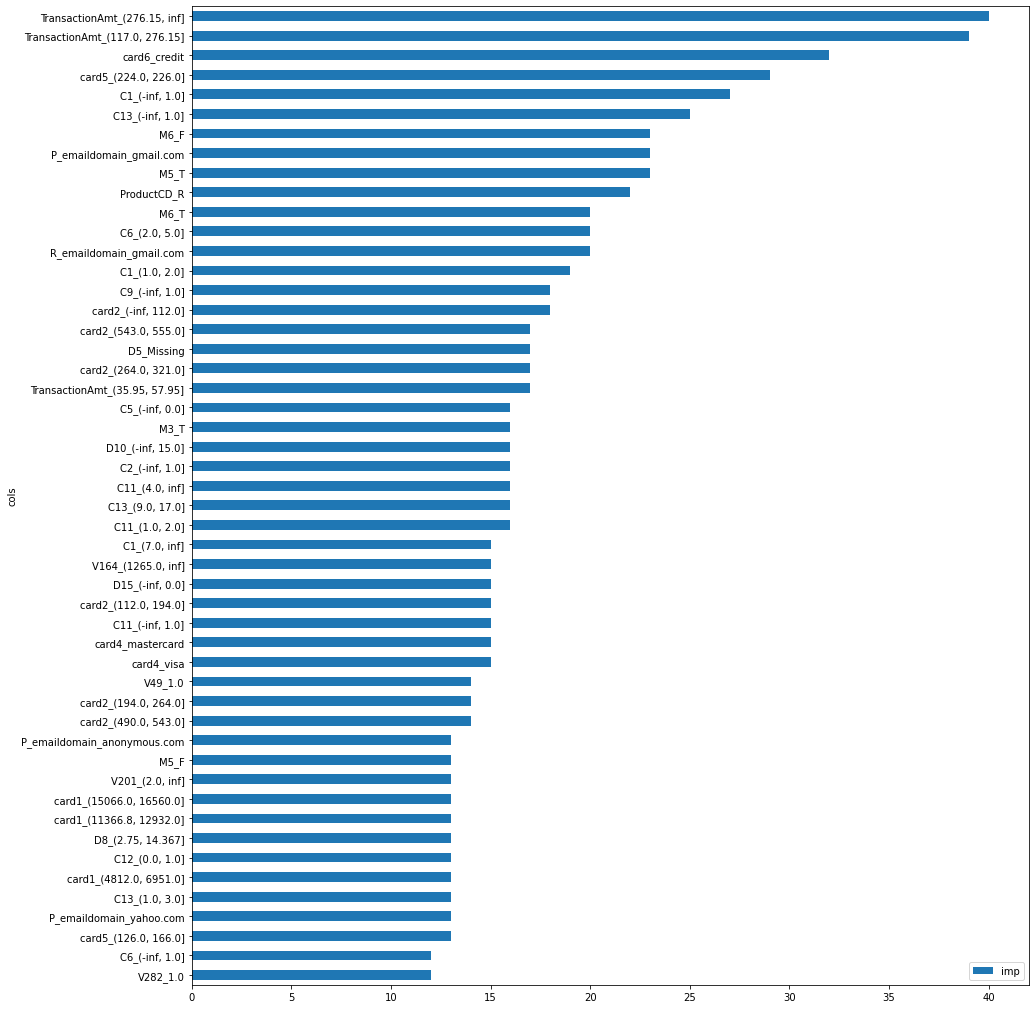

In [56]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : model_n2.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:50]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(15,18))
plt.show()

#### Using Hyperopt

In [57]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import make_scorer

In [58]:
def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

In [59]:
def gini(truth, predictions):
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

In [57]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'min_child_samples': int(params['min_child_samples']),        
        'learning_rate' : '{:.3f}'.format(params['learning_rate']),
        'max_depth' : int(params['max_depth']),
        'scale_pos_weight': '{:.3f}'.format(params['scale_pos_weight']),
        'min_child_weight': '{:.3f}'.format(params['min_child_weight']),
        'subsample_for_bin':  int(params['subsample_for_bin'])
    }
    
    clf = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        eval_metric = 'auc',
        boosting_type= "goss",
        
        **params
    )
    
    score = cross_val_score(clf, x_train, y_train, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1.0),
    'min_child_samples': hp.quniform('min_child_samples', 8, 128, 2),
    'learning_rate': hp.uniform('learning_rate', 0,1),
    'max_depth' :hp.quniform('max_depth', 1, 5, 2),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0,1),
    'min_child_weight': hp.uniform('min_child_weight', 0,1),
    'subsample_for_bin':  hp.quniform('subsample_for_bin', 100, 50000, 10)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Gini 0.709 params {'num_leaves': 126, 'colsample_bytree': '0.511', 'feature_fraction': '0.542', 'min_child_samples': 48, 'learning_rate': '0.274', 'max_depth': 2, 'scale_pos_weight': '0.222', 'min_child_weight': '0.257', 'subsample_for_bin': 26290}
Gini 0.691 params {'num_leaves': 46, 'colsample_bytree': '0.606', 'feature_fraction': '0.592', 'min_child_samples': 124, 'learning_rate': '0.586', 'max_depth': 4, 'scale_pos_weight': '0.614', 'min_child_weight': '0.719', 'subsample_for_bin': 22100}
Gini 0.667 params {'num_leaves': 64, 'colsample_bytree': '0.867', 'feature_fraction': '0.548', 'min_child_samples': 104, 'learning_rate': '0.801', 'max_depth': 4, 'scale_pos_weight': '0.392', 'min_child_weight': '0.504', 'subsample_for_bin': 1870}
Gini 0.683 params {'num_leaves': 124, 'colsample_bytree': '0.775', 'feature_fraction': '0.369', 'min_child_samples': 90, 'learning_rate': '0.024', 'max_depth': 4, 'scale_pos_weight': '0.353', 'min_child_weight': '0.622', 'subsample_for_bin': 28760}
Gini 

In [58]:
format(best)

"{'colsample_bytree': 0.30462363080983534, 'feature_fraction': 0.77123971334186, 'learning_rate': 0.775422159445153, 'max_depth': 4.0, 'min_child_samples': 34.0, 'min_child_weight': 0.8253596822819328, 'num_leaves': 116.0, 'scale_pos_weight': 0.6708728256022322, 'subsample_for_bin': 42120.0}"

In [60]:
clf2 = LGBMClassifier(colsample_bytree= 0.6705459836183462, feature_fraction= 0.5243861441073344, 
                      learning_rate= 0.716932725777755, max_depth= 4, min_child_samples= 38, 
                      min_child_weight= 0.9388034294242809, num_leaves= 106, scale_pos_weight= 0.9616172899919058, 
                      subsample_for_bin= 390)

In [61]:
clf2.fit(x_train,y_train)

LGBMClassifier(colsample_bytree=0.6705459836183462,
               feature_fraction=0.5243861441073344,
               learning_rate=0.716932725777755, max_depth=4,
               min_child_samples=38, min_child_weight=0.9388034294242809,
               num_leaves=106, scale_pos_weight=0.9616172899919058,
               subsample_for_bin=390)

In [61]:

clf2.fit(x_train,y_train)
pred = clf2.predict(x_valid) 
fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred)
precision, recall, thresholds = precision_recall_curve(y_valid, pred)

print('AUC :',metrics.auc(fpr, tpr)) 
print('Accuracy Score :',accuracy_score(y_valid, pred)) 
print('precision :',precision[1]) 
print('recall :',recall[1]) 


AUC : 0.687796796175147
Accuracy Score : 0.9682031796820318
precision : 0.6025641025641025
recall : 0.38524590163934425


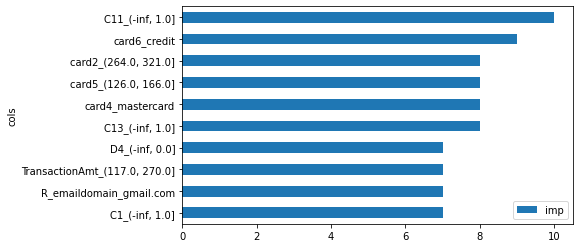

In [77]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf2.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:10]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(7,4))
plt.show()

In [62]:
fi['cols']

1023                C13_(-inf, 1.0]
478            card5_(224.0, 226.0]
9                      card6_credit
966     TransactionAmt_(280.0, inf]
2                       ProductCD_R
                   ...             
577                    V299_Missing
578                    V151_Missing
579               V151_(-inf, 25.3]
580                V151_(25.3, inf]
1205               V339_(50.0, inf]
Name: cols, Length: 1206, dtype: object

In [ ]:
#### Bayesian HyperOpt

In [63]:
import lightgbm as lgb

from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score

In [64]:
def lgb_evaluate(                
                numLeaves,
                maxDepth,
                scale_pos_weight,
                minChildWeight,
                subsample_for_bin,
                colsample_bytree,
                learning_rate
                ,min_child_samples, feature_fraction
                ):
    
    clf = lgb.LGBMClassifier(
        objective = 'binary',
        #metric= 'auc',
        boosting_type = 'goss',
        eval_metric= 'auc',
        #reg_alpha= 0,
        #reg_lambda= 2,
        #bagging_fraction= 0.999,
        #min_split_gain= 0,
        #min_child_samples= 10,
        #subsample_freq= 3,
        #subsample_for_bin= 500,
        #n_estimators= 9999999,
        num_leaves= int(numLeaves),
        max_depth= int(maxDepth),
        scale_pos_weight= scale_pos_weight,
        min_child_weight= minChildWeight,
        subsample_for_bin= int(subsample_for_bin),
        colsample_bytree= colsample_bytree,
        learning_rate =learning_rate,
        verbose =-1,
        min_child_samples = int(min_child_samples),        feature_fraction = feature_fraction
    )
    
    scores = cross_val_score(clf,x_train,y_train, cv=5, scoring='roc_auc')
    print(np.mean(scores))

    return np.mean(scores)
   
def bayesOpt(X, y):
    lgbBO = BayesianOptimization(lgb_evaluate, {                                                
                                                'numLeaves':  (2 ,128),
                                                'maxDepth': (2, 10),
                                                'scale_pos_weight': (0,1),
                                                'minChildWeight': (0, 1),
                                                'subsample_for_bin': (10,5000),
                                                'colsample_bytree': (0,1),
                                                'learning_rate' :(0,1),
                                                 'min_child_samples': (2,50),
                                                 'feature_fraction':(0, 1)
        
                                                
                                            })


    lgbBO.maximize(init_points=5, n_iter=5)

    #print(lgbBO.res['max'])
    

bayesOpt(x_train,y_train)

|   iter    |  target   | colsam... | featur... | learni... | maxDepth  | minChi... | min_ch... | numLeaves | scale_... | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
0.8547662903207469
|  1        |  0.8548   |  0.457    |  0.6052   |  0.1687   |  7.311    |  0.8496   |  25.28    |  4.246    |  0.1878   |  197.0    |
0.8750434901251832
|  2        |  0.875    |  0.8023   |  0.554    |  0.06783  |  9.132    |  0.8028   |  24.8     |  47.54    |  0.7506   |  2.073e+0 |
0.6416737018339758
|  3        |  0.6417   |  0.6369   |  0.6228   |  0.9659   |  5.458    |  0.5765   |  48.89    |  21.11    |  0.7512   |  256.9    |
0.828182027492581
|  4        |  0.8282   |  0.7907   |  0.2104   |  0.6248   |  6.133    |  0.4651   |  31.8     |  49.8     |  0.02709  |  36.9     |
0.8627949085286126
|  5        |  0.8628   |  0.6168   |  0.2437   |  0.2301   |  5.783    |  0.1777   |  35.89    |  48.

In [65]:
clf3 = LGBMClassifier(colsample_bytree= 0.6915, feature_fraction=0.4943 , 
                      learning_rate= 0.3064 , max_depth= 6 , min_child_samples= 44  , 
                      min_child_weight= 0.8296  , num_leaves= 19, scale_pos_weight=  0.4535 , 
                      subsample_for_bin= 17)

In [ ]:
colsam... | featur... | learni... | maxDepth  | minChi... | min_ch... | numLeaves | scale_... | subsam... |
0.6915   |  0.4943   |  0.3064   |  6.379    |  0.8296   |  44.5     |  19.06    |  0.4535   |  1.711e+0 |

In [66]:
clf3.fit(x_train,y_train)
pred3 = clf3.predict(x_valid) 
fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred3)
precision, recall, thresholds = precision_recall_curve(y_valid, pred3)

print('AUC :',metrics.auc(fpr, tpr)) 
print('Accuracy Score :',accuracy_score(y_valid, pred3)) 
print('precision :',precision[1]) 
print('recall :',recall[1]) 


AUC : 0.6557026834656209
Accuracy Score : 0.9722027797220278
precision : 0.8098591549295775
recall : 0.31420765027322406


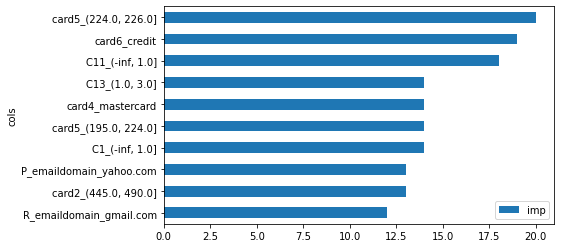

In [68]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf3.feature_importances_})
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:10]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(7,4))
plt.show()

In [69]:
fi['cols']

478     card5_(224.0, 226.0]
9               card6_credit
1016         C11_(-inf, 1.0]
982           C1_(-inf, 1.0]
476     card5_(195.0, 224.0]
                ...         
586          V228_(2.0, inf]
587             V201_Missing
589          V201_(1.0, 2.0]
590          V201_(2.0, inf]
1205        V339_(50.0, inf]
Name: cols, Length: 1206, dtype: object

### Grid and Random Search

In [63]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [64]:
import lightgbm as lgbm
dtrain = lgbm.Dataset(x_train, label=y_train)
dval = lgbm.Dataset(x_valid, label=y_valid)

In [65]:
import lightgbm as lgbm
clf_LGBM = lgbm.LGBMClassifier(objective='binary')
clf_LGBM.fit(x_train, y_train)

LGBMClassifier(objective='binary')

In [66]:
param_grid = {
    #'n_estimators': [500, 600],
    'colsample_bytree': [ 0,1],
    'learning_rate': [0,1],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9, ],
    'min_child_samples': [2,50],
    'scale_pos_weight': [0,1],
    'minChildWeight': [0, 1],
    'feature_fraction':[0, 1]                
}
clf_LGBM = lgbm.LGBMClassifier(objective='binary',is_unbalance= True,
        boosting_type = 'goss',
        eval_metric= 'auc')



grid_search_lgbm= GridSearchCV(estimator = clf_LGBM, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)



In [67]:
# Fit the grid search to the data 
grid_search_lgbm.fit(x_train, y_train)
grid_search_lgbm.best_params_

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 18.2min


KeyboardInterrupt: 

In [146]:
pred4 = grid_search_lgbm.predict(x_valid) 
fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred4)
precision, recall, thresholds = precision_recall_curve(y_valid, pred4)

print('AUC :',metrics.auc(fpr, tpr)) 
print('Accuracy Score :',accuracy_score(y_valid, pred4)) 
print('precision :',precision[1]) 
print('recall :',recall[1]) 

AUC : 0.6414077584168256
Accuracy Score : 0.5497450254974503
precision : 0.05482972799314628
recall : 0.7398843930635838


In [164]:
clf5 = LGBMClassifier(colsample_bytree= 0, feature_fraction=1 , 
                      learning_rate= 1 , max_depth= 15 , min_child_samples= 50  , 
                      min_child_weight= 0  , num_leaves= 50, scale_pos_weight=  1 , 
                      subsample= .7,objective='binary',
        boosting_type = 'goss',
        eval_metric= 'auc')
clf5.fit(x_train,y_train)

LGBMClassifier(boosting_type='goss', colsample_bytree=0, eval_metric='auc',
               feature_fraction=1, learning_rate=1, max_depth=15,
               min_child_samples=50, min_child_weight=0, num_leaves=50,
               objective='binary', scale_pos_weight=1, subsample=0.7)

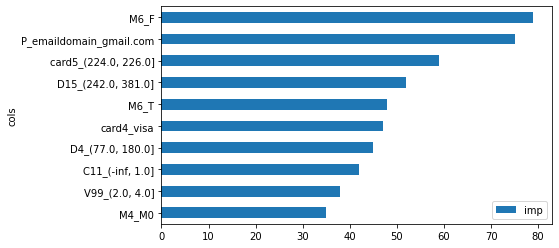

In [165]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf5.feature_importances_ })
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:10]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(7,4))
plt.show()

In [166]:
fi['cols']

14                         M6_F
984     P_emaildomain_gmail.com
474        card5_(224.0, 226.0]
1114         D15_(242.0, 381.0]
15                         M6_T
                 ...           
431                    V23_Rare
815                V273_Missing
447                    V300_0.0
812                V128_Missing
609                V180_Missing
Name: cols, Length: 1219, dtype: object

In [145]:
param_grid1= {
    'colsample_bytree': [ 0,1],
    'learning_rate': [0.6,0.7, 0.8, 0.9],
    'max_depth': [10,15,20,25],
    'num_leaves': [50, 100, 200],
    'subsample': [0.6,0.7, 0.8, 0.9 ],
    'min_child_samples': [2,50],
    'scale_pos_weight': [0,1],
    'minChildWeight': [0, 1],
    'feature_fraction':[0.6,0.7, 0.8, 0.9] 
  
    
}
clf_LGBM1 = lgbm.LGBMClassifier(objective='binary',is_unbalance= True)


Random_search_lgbm= RandomizedSearchCV(estimator = clf_LGBM1,  param_distributions= param_grid1, n_iter = 10,
                          cv = 3, n_jobs = -1, verbose = 2, random_state=100 )


# Fit the grid search to the data 
Random_search_lgbm.fit(x_train, y_train)
Random_search_lgbm.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


{'subsample': 0.9,
 'scale_pos_weight': 1,
 'num_leaves': 200,
 'min_child_samples': 2,
 'minChildWeight': 1,
 'max_depth': 25,
 'learning_rate': 0.6,
 'feature_fraction': 0.7,
 'colsample_bytree': 1}

In [ ]:
best_grid_lgbm1 = Random_search_lgbm.best_estimator_


y_pred_train_random_rf1= Random_search_lgbm.predict(x_train)
y_pred_grid_random_rf1= Random_search_lgbm.predict(x_valid)
# Model Accuracy, how often is the classifier correct?

print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train_random_rf1)) 

print("Valid Accuracy:",metrics.accuracy_score(y_valid, y_pred_grid_random_rf1))  
print(classification_report(y_valid, y_pred_grid_valid_rf1))

In [147]:
pred5 = Random_search_lgbm.predict(x_valid) 
fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred5)
precision, recall, thresholds = precision_recall_curve(y_valid, pred5)

print('AUC :',metrics.auc(fpr, tpr)) 
print('Accuracy Score :',accuracy_score(y_valid, pred5)) 
print('precision :',precision[1]) 
print('recall :',recall[1]) 

AUC : 0.6797472333062926
Accuracy Score : 0.6614338566143385
precision : 0.06867196367763904
recall : 0.6994219653179191


In [167]:
clf6 = LGBMClassifier(colsample_bytree= 1, feature_fraction=.7 , 
                      learning_rate= .6 , max_depth= 25 , min_child_samples= 2, 
                      min_child_weight= 1  , num_leaves= 200, scale_pos_weight=  1 , 
                      subsample= 0.9,objective='binary',
        boosting_type = 'goss',
        eval_metric= 'auc')
clf6.fit(x_train,y_train)

LGBMClassifier(boosting_type='goss', colsample_bytree=1, eval_metric='auc',
               feature_fraction=0.7, learning_rate=0.6, max_depth=25,
               min_child_samples=2, min_child_weight=1, num_leaves=200,
               objective='binary', scale_pos_weight=1, subsample=0.9)

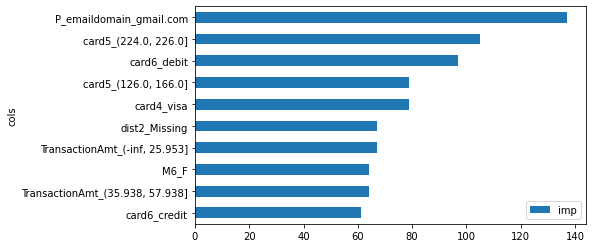

In [168]:
fi=pd.DataFrame({'cols' : litraincolOrg, 'imp' : clf6.feature_importances_ })
fi = fi.sort_values('imp', ascending=False)
top_50 = fi[0:10]
top_50 = top_50.sort_values('imp', ascending=True)
# Plot the bar chart
top_50.plot(x='cols', kind='barh' , figsize=(7,4))
plt.show()

In [169]:
fi['cols']

984    P_emaildomain_gmail.com
474       card5_(224.0, 226.0]
8                  card6_debit
5                   card4_visa
472       card5_(126.0, 166.0]
                ...           
910               V186_Missing
614           V253_(-inf, inf]
615               V253_Missing
907               V183_Missing
609               V180_Missing
Name: cols, Length: 1219, dtype: object

In [ ]:
### MultiThreading

In [171]:
import multiprocessing as mp
import numpy as np
import tqdm
from itertools import repeat
from multiprocessing import Process, Manager
from multiprocessing import Pool
import pandas as pd


num_processes = mp.cpu_count()

print("Number of cpu : ", num_processes)

Number of cpu :  4


In [176]:
# importing the multiprocessing module 
import multiprocessing 
import os 

def worker1(): 
	# printing process id 
	print("ID of process running worker1: {}".format(os.getpid())) 

def worker2(): 
	# printing process id 
	print("ID of process running worker2: {}".format(os.getpid())) 

if __name__ == "__main__": 
	# printing main program process id 
	print("ID of main process: {}".format(os.getpid())) 

	# creating processes 
	p1 = multiprocessing.Process(target=worker1) 
	p2 = multiprocessing.Process(target=worker2) 

	# starting processes 
	p1.start() 
	p2.start() 

	# process IDs 
	print("ID of process p1: {}".format(p1.pid)) 
	print("ID of process p2: {}".format(p2.pid)) 

	# wait until processes are finished 
	p1.join() 
	p2.join() 

	# both processes finished 
	print("Both processes finished execution!") 

	# check if processes are alive 
	print("Process p1 is alive: {}".format(p1.is_alive())) 
	print("Process p2 is alive: {}".format(p2.is_alive())) 


ID of main process: 3132
ID of process p1: 9648
ID of process p2: 7376
Both processes finished execution!
Process p1 is alive: False
Process p2 is alive: False


In [ ]:
from multiprocessing import Pool

In [179]:
from multiprocessing import Pool

def func1():
    print('func1: starting') 
    for i in xrange(10000000): pass
    print('func1: finishing')  #'func1: '
    
def func2():
    print('func2: starting')
    for i in xrange(10000000): pass
    print('func2: finishing')

if __name__ == '__main__':
    p1 = Process(target=func1)
    p1.start()
    p2 = Process(target=func2)
    p2.start()
    p1.join()
    p2.join()

In [180]:
def runInParallel(*fns):
    proc = []
    for fn in fns:        
        p = Process(target=fn)
        p.start()
        proc.append(p)
    for p in proc:
        p.join()

runInParallel(func1, func2)

In [187]:
from concurrent.futures import ThreadPoolExecutor

def run_io_tasks_in_parallel(tasks):
    with ThreadPoolExecutor() as executor:
        running_tasks = [executor.submit(task) for task in tasks]
        for running_task in running_tasks:
            running_task.result()

run_io_tasks_in_parallel(li_model)

TypeError: 'LGBMClassifier' object is not callable

Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\user\Anaconda4\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\user\Anaconda4\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\user\Anaconda4\lib\multiprocessing\pool.py", line 513, in _handle_workers
    cls._maintain_pool(ctx, Process, processes, pool, inqueue,
  File "C:\Users\user\Anaconda4\lib\multiprocessing\pool.py", line 337, in _maintain_pool
    Pool._repopulate_pool_static(ctx, Process, processes, pool,
  File "C:\Users\user\Anaconda4\lib\multiprocessing\pool.py", line 326, in _repopulate_pool_static
    w.start()
  File "C:\Users\user\Anaconda4\lib\multiprocessing\process.py", line 121, in start
    self._popen = self._Popen(self)
  File "C:\Users\user\Anaconda4\lib\multiprocessing\context.py", line 326, in _Popen
    return Popen(process_obj)
  File "C:\Users\user\Anaconda4\lib\multiprocessing\popen_spawn_win3

In [186]:
li_model=[]
model_names = [clf_LGBM,clf3,clf5]
for clf in model_names:
    li_model.append(clf.fit(x_train,y_train))
    
    

In [ ]:
import time
import random

from multiprocessing import Process, Queue, current_process, freeze_support

#
# Function run by worker processes
#

def worker(input, output):
    for func, args in iter(input.get, 'STOP'):
        result = calculate(func, args)
        output.put(result)

#
# Function used to calculate result
#

def calculate(func, args):
    result = func(*args)
    return '%s says that %s%s = %s' % \
        (current_process().name, func.__name__, args, result)

#
# Functions referenced by tasks
#

def mul(a, b):
    time.sleep(0.5*random.random())
    return a * b

def plus(a, b):
    time.sleep(0.5*random.random())
    return a + b

#
#
#

def test():
    NUMBER_OF_PROCESSES = 4
    TASKS1 = [(mul, (i, 7)) for i in range(20)]
    TASKS2 = [(plus, (i, 8)) for i in range(10)]

    # Create queues
    task_queue = Queue()
    done_queue = Queue()

    # Submit tasks
    for task in TASKS1:
        task_queue.put(task)

    # Start worker processes
    for i in range(NUMBER_OF_PROCESSES):
        Process(target=worker, args=(task_queue, done_queue)).start()

    # Get and print results
    print('Unordered results:')
    for i in range(len(TASKS1)):
        print('\t', done_queue.get())

    # Add more tasks using `put()`
    for task in TASKS2:
        task_queue.put(task)

    # Get and print some more results
    for i in range(len(TASKS2)):
        print('\t', done_queue.get())

    # Tell child processes to stop
    for i in range(NUMBER_OF_PROCESSES):
        task_queue.put('STOP')


if __name__ == '__main__':
    freeze_support()
    test()

Unordered results:


In [ ]:
employee_df = pd.read_csv('employee.csv',low_memory=False)
data_df = pd.read_csv('data.csv',low_memory=False)

data_df['date']= pd.to_datetime(data_df['date']) 

print(employee_df.head())
print(data_df.head())

In [174]:
model_names = ['clf_LGBM','clf3','clf5']

In [ ]:
name_dict = {}
for index,row in employee_df.iterrows():
    name_dict[row['ecode']] = row['ename']

empcodes= []
empcodes.extend(list(data_df['employee_code'].unique()))

    
print(name_dict)
print(empcodes[:10])

In [172]:
num_partitions = num_processes
manager = Manager()
d = manager.dict()

In [175]:
df_split = np.array_split(model_names, num_partitions)
pool = Pool(num_processes)
shared_arg = repeat(d,num_partitions)

In [ ]:

for _ in tqdm.tqdm(pool.map(process_rows, zip(shared_arg,df_split)), total=num_partitions):
    pass
pool.close()
pool.join()

In [ ]:
def process_rows(model_names,):
    d = data[0]
    df = data[1]
    for index,row in df.iterrows():
        ecode = int(row['employee_code'])
        month = int(row['date'].month)
        efficiency = int(row['efficiency'])
        if (ecode,month) in list(d.keys()):
            d[ecode,month] = (efficiency + d[ecode,month]) / 2
        else:
            d[ecode,month] = efficiency

In [ ]:
import datetime
months = []
for i in range(1,13):
    month = datetime.date(1900,i, 1).strftime('%B')
    months.append(month)

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
data = []
for ecode in empcodes:
    y_list = []
    for i in range(1,13):
        y_list.append(d[int(ecode),i])
    data.append(go.Scatter(
    x=months,
    y=list(y_list),
    name = name_dict[str(ecode)]
    ))
layout = go.Layout(
    title='Employee Analysis',
    xaxis=dict(title='Months in 2018',),
    yaxis=dict(title='Average Production Efficieny per month',)
)

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='Employee-Efficiency.html')